# 0 - Importing relevant libraries and data

In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore, f_oneway

# Warnings and style
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  
sns.set_theme(style="whitegrid")  # Clean Seaborn style

## 0.1 - importing the data and creating a data frame

https://www.kaggle.com/datasets/adilshamim8/social-media-addiction-vs-relationships

In [685]:
df = pd.read_csv("Students Social Media Addiction.csv")
print(df.head())

   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationship_Status  Conflicts_Over_Soc

# 1 - Genaral Analysis of the Dataset

## 1.1 - General overview

###  Data Shape

In [686]:
print(df.shape)

(705, 13)


**705 Students were involve in this study**

### Data Describe

In [687]:
desc = df.describe().T

desc.style.applymap(
    lambda v: 'background-color: #1B2631'  
).format("{:.2f}")


,count,mean,std,min,25%,50%,75%,max
Student_ID,705.00,353.00,203.66,1.00,177.00,353.00,529.00,705.00
Age,705.00,20.66,1.40,18.00,19.00,21.00,22.00,24.00
Avg_Daily_Usage_Hours,705.00,4.92,1.26,1.50,4.10,4.80,5.80,8.50
Sleep_Hours_Per_Night,705.00,6.87,1.13,3.80,6.00,6.90,7.70,9.60
Mental_Health_Score,705.00,6.23,1.11,4.00,5.00,6.00,7.00,9.00
Conflicts_Over_Social_Media,705.00,2.85,0.96,0.00,2.00,3.00,4.00,5.00
Addicted_Score,705.00,6.44,1.59,2.00,5.00,7.00,8.00,9.00


### Data Type

In [688]:
desc = pd.DataFrame({
    'Non-Null Count': df.notnull().sum(),
    'Dtype': df.dtypes
})
desc.style.applymap(lambda v: 'background-color: #1B2631')

,Non-Null Count,Dtype
Student_ID,705,int64
Age,705,int64
Gender,705,object
Academic_Level,705,object
Country,705,object
Avg_Daily_Usage_Hours,705,float64
Most_Used_Platform,705,object
Affects_Academic_Performance,705,object
Sleep_Hours_Per_Night,705,float64
Mental_Health_Score,705,int64


___

## 1.2 Data Distribution


**Column Type Classification: Categorical vs Numeric**

In this notebook, we classify the dataset's columns into **categorical** and **numeric** types to facilitate proper analysis and visualization.

Why this distinction is important:
- **Categorical variables** (e.g., `Gender`, `Academic_Level`) represent discrete groups or labels.
  - Best visualized with **bar plots**
  - Often require **encoding** (e.g., one-hot encoding) before being used in machine learning models
- **Numeric variables** (e.g.`Avg_Daily_Usage_Hours`) represent continuous or ordinal quantities.
  - Best visualized with **histograms**
  - May require **normalization or scaling**

How classification is performed:
- Columns with data types `object` or `category` are considered **categorical**
- Columns with a **low unique ratio** (i.e., number of unique values divided by total rows < 0.05) are also treated as **categorical**
- All other columns are classified as **numeric**

This automated classification helps ensure:
- Clear and appropriate visualizations
- Correct preprocessing steps for different types of data



,Unique Values,Missing Values,Unique Ratio,Suggested Type
Age,7,0,0.009929,Categorical
Gender,2,0,0.002837,Categorical
Academic_Level,3,0,0.004255,Categorical
Avg_Daily_Usage_Hours,67,0,0.095035,Numeric
Most_Used_Platform,12,0,0.017021,Categorical
Affects_Academic_Performance,2,0,0.002837,Categorical
Sleep_Hours_Per_Night,59,0,0.083688,Numeric
Mental_Health_Score,6,0,0.008511,Categorical
Relationship_Status,3,0,0.004255,Categorical
Conflicts_Over_Social_Media,6,0,0.008511,Categorical


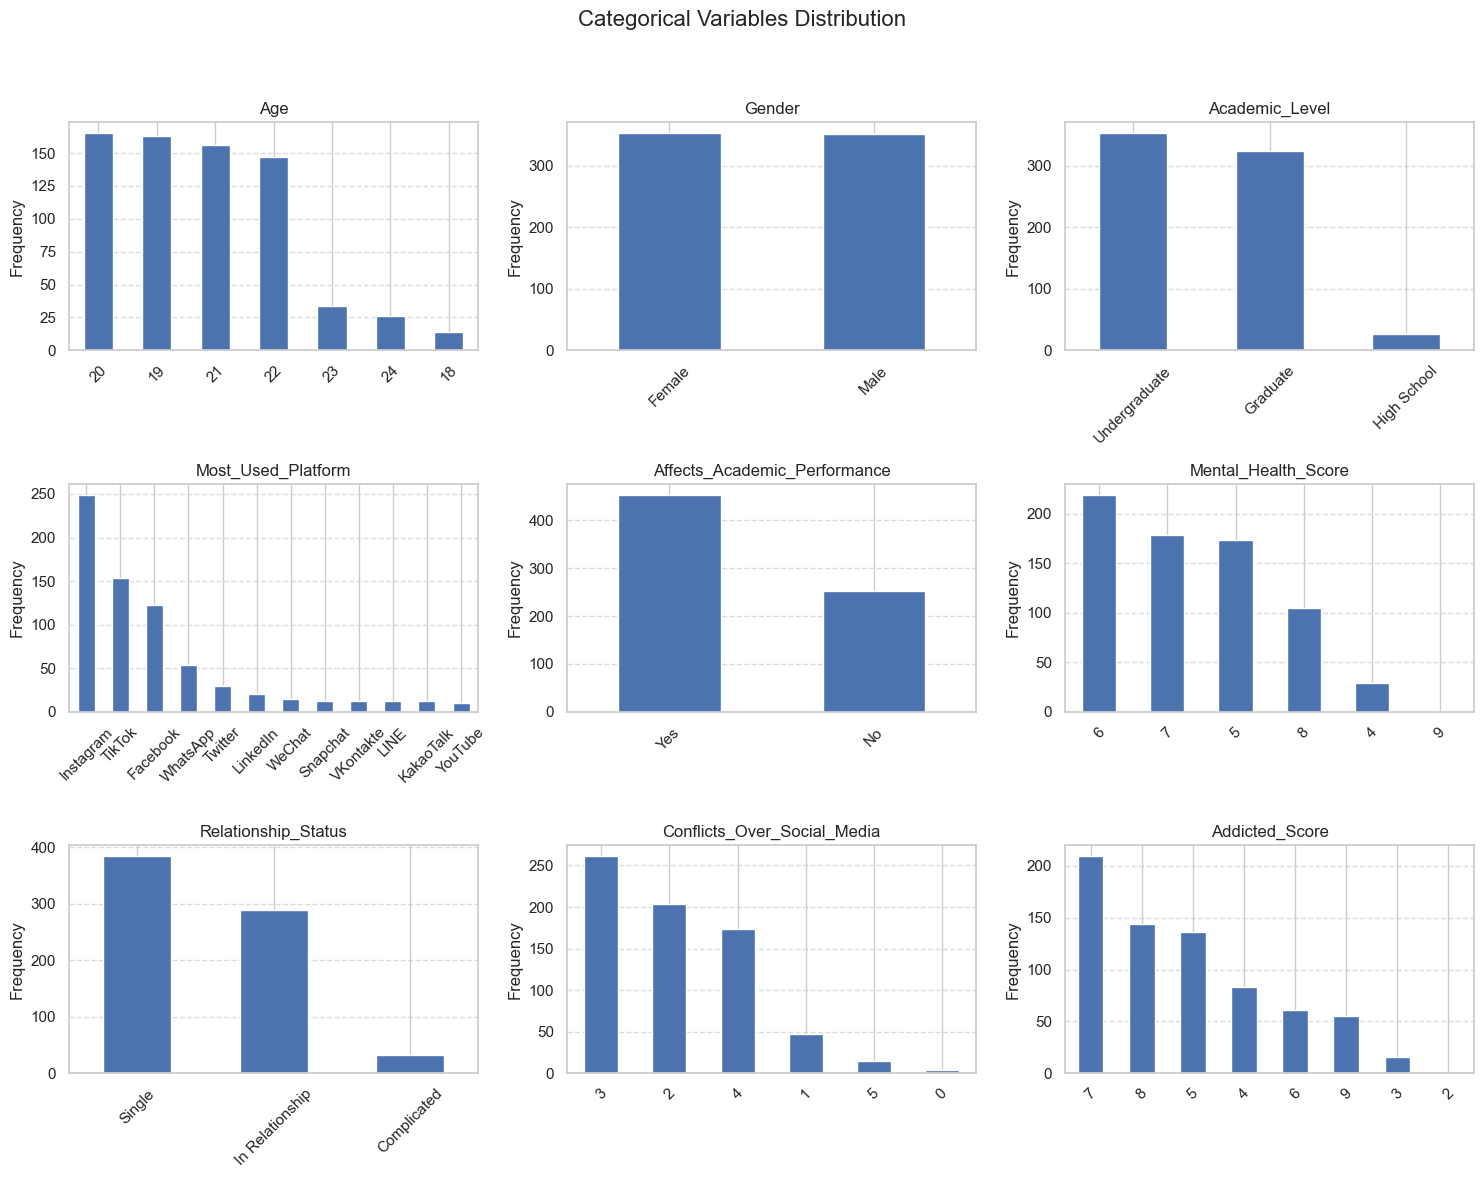

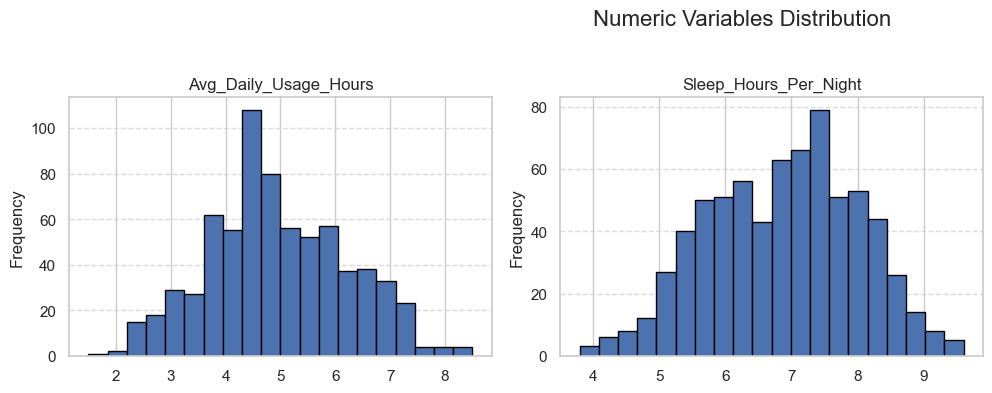

The categorical columns: ['Age', 'Gender', 'Academic_Level', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Mental_Health_Score', 'Relationship_Status', 'Conflicts_Over_Social_Media', 'Addicted_Score']
The numric columns: ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']


In [689]:
from data_prep import analyze_dataframe

exclude_cols=['Student_ID', 'Country']

summary, categorical_cols, numeric_cols = analyze_dataframe(df, exclude_cols=exclude_cols)
print( "The categorical columns:", categorical_cols)
print( "The numric columns:", numeric_cols)

**Some variables that are considerd categorical are ordinal**
- 'Age',
- 'Mental_Health_Score',
- 'Conflicts_Over_Social_Media',
- 'Addicted_Score'

**There is also a binary variable**
- 'Affects_Academic_Performance'

We excluded the 'Country' variable from the analysis, as the dataset includes a large number of countries and our focus is not on cross-national differences

___

## 1.3 Normalization of Numerical Values


Only 'Avg_Daily_Usage_Hours' and 'Sleep_Hours_Per_Night' were standardized, as they are the only numerical features. Ordinal variables were retained as-is to preserve their meaningful order and because normalization is unnecessary for this type.


In [690]:
from data_prep import standardize_numeric_columns

st_clean_df = standardize_numeric_columns(df)
desc = st_clean_df.describe().T
desc.style.applymap(lambda v: 'background-color: # 959595').format("{:.2f}")

Standardized columns: ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']


,count,mean,std,min,25%,50%,75%,max
Student_ID,705.00,353.00,203.66,1.00,177.00,353.00,529.00,705.00
Age,705.00,20.66,1.40,18.00,19.00,21.00,22.00,24.00
Avg_Daily_Usage_Hours,705.00,0.00,1.00,-2.72,-0.65,-0.09,0.70,2.85
Sleep_Hours_Per_Night,705.00,-0.00,1.00,-2.73,-0.77,0.03,0.74,2.43
Mental_Health_Score,705.00,6.23,1.11,4.00,5.00,6.00,7.00,9.00
Conflicts_Over_Social_Media,705.00,2.85,0.96,0.00,2.00,3.00,4.00,5.00
Addicted_Score,705.00,6.44,1.59,2.00,5.00,7.00,8.00,9.00


**Histogram and KDE Plots of Standardized Variables**

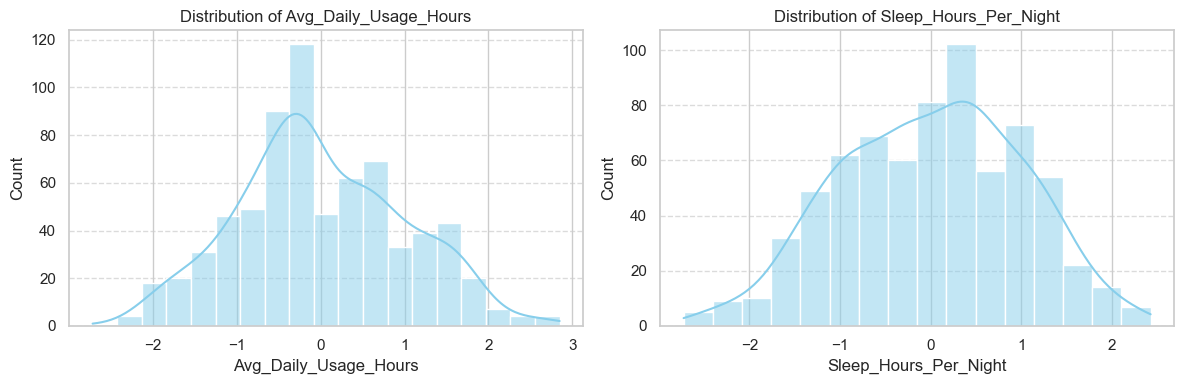

In [691]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(st_clean_df[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()

**The data was standardized to have a mean of 0 and a standard deviation of 1**

## 1.4 – Normality Assessment of Numerical Features (Shapiro-Wilk Test & Q-Q Plots)



Avg_Daily_Usage_Hours
Shapiro-Wilk p-value: 0.0008
The data is not normally distributed (reject H0)


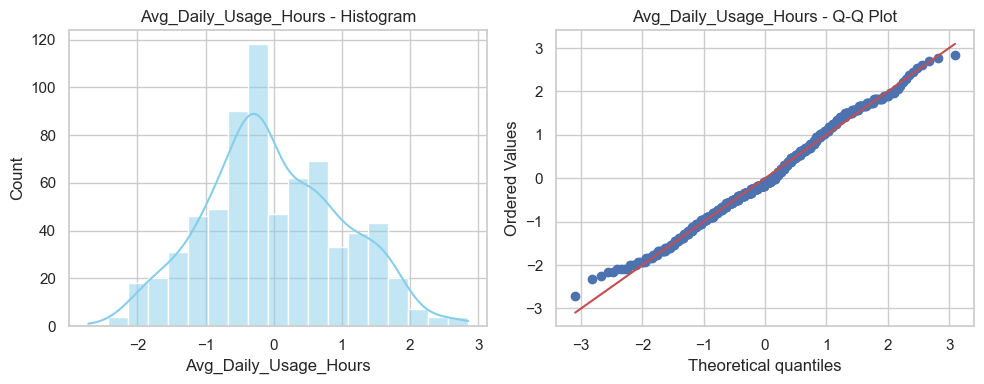


Sleep_Hours_Per_Night
Shapiro-Wilk p-value: 0.0020
The data is not normally distributed (reject H0)


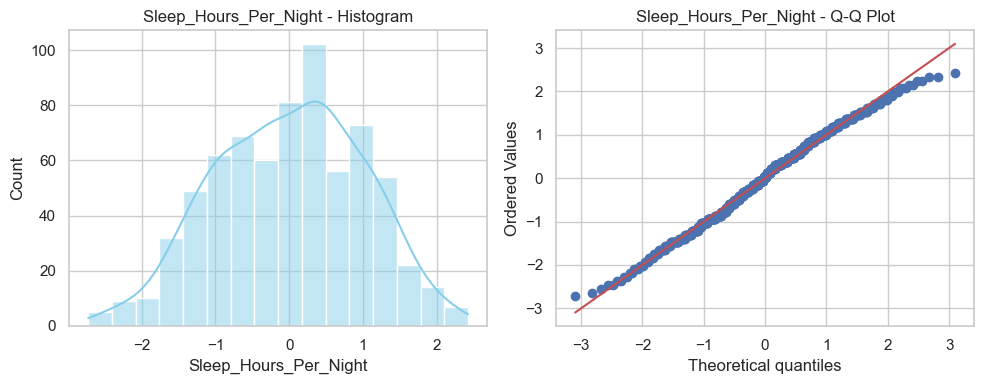

In [692]:
from scipy.stats import shapiro
import scipy.stats as stats

def check_normality(df, numeric_cols, alpha=0.05):
    for col in numeric_cols:
        data = df[col].dropna()
        
        # Shapiro-Wilk Test
        stat, p_value = shapiro(data)

        print(f"\n{col}")
        print(f"Shapiro-Wilk p-value: {p_value:.4f}")
        if p_value < alpha:
            print("The data is not normally distributed (reject H0)")
        else:
            print("The data is normally distributed (fail to reject H0)")

        # Plots: Histogram + Q-Q Plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Histogram
        sns.histplot(data, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f"{col} - Histogram")
        axes[0].grid(True)

        # Q-Q Plot
        stats.probplot(data, dist="norm", plot=axes[1])
        axes[1].set_title(f"{col} - Q-Q Plot")

        plt.tight_layout()
        plt.show()

# Run the function
check_normality(st_clean_df, numeric_cols)


Both ***Avg_Daily_Usage_Hours*** and ***Sleep_Hours_Per_Night*** returned statistically significant results (p < 0.01), indicating that their distributions deviate from normality. 

> This is visually supported by the slight deviations from the reference line in the Q-Q plots, especially at the tails.
___

## 1.5 - Encoding of Categorical Variable

In [693]:
# Convert binary categorical variable to numeric (Yes = 1, No = 0)
st_clean_df['Affects_Academic_Performance'] = st_clean_df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})
df['Affects_Academic_Performance'] = df['Affects_Academic_Performance'].map({'Yes': 1, 'No': 0})
# Map academic levels to ordinal numeric values (reflecting increasing education level)
st_clean_df['Academic_Level'] = st_clean_df['Academic_Level'].map({
    'High School': 0,
    'Undergraduate': 1,
    'Graduate': 2
})

# Map relationship status to ordinal numeric values (reflecting relationship complexity)
st_clean_df['Relationship_Status'] = st_clean_df['Relationship_Status'].map({
    'Single': 0,
    'Complicated': 1,
    'In Relationship': 2
})


**We applied ordinal encoding to selected categorical variables in order to reflect an implied order or progression in the data. **

For instance:
- Academic_Level was encoded based on the increasing level of education.

- Relationship_Status was assigned numeric values to reflect a subjective increase in relational complexity or involvement.

- The binary variable Affects_Academic_Performance was converted to 1/0 for analytical use.

> This ordinal mapping allows machine learning models and statistical tests to interpret the order inherent in these variables without assuming they are nominal.
___

# 2 – Exploratory Analysis Focused on 'Academic Performance' and 'Mental Health'

## 2.1 - Correlation Analysis


***Pearson correlation will not be used, as the numerical variables did not meet the normality assumption required for reliable interpretation.***

***Instead, we chose Spearman correlation its suitability for non-normal, ordinal, and monotonic data.***

___

### 2.1.1 – Spearman Correlation Matrix of Numerical and Ordinal Variables


***Pearson correlation was not used, as the numerical variables did not meet the normality assumption required for reliable interpretation.***

***Instead, Spearman correlation was chosen due to its suitability for non-normal, ordinal, and monotonic data.***

___

Spearman's correlation matrix measures the strength and direction of **monotonic relationships** between pairs of variables, using **ranked values** instead of raw data. It is especially useful for non-normally distributed or ordinal data.

The Spearman correlation coefficient $\rho$ is calculated as:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

where:
- $d_i$ is the difference between the ranks of each observation
- $n$ is the number of paired values

A value of $\rho = 1$ indicates a perfect increasing relationship, $\rho = -1$ a perfect decreasing one, and $\rho = 0$ indicates no monotonic correlation.


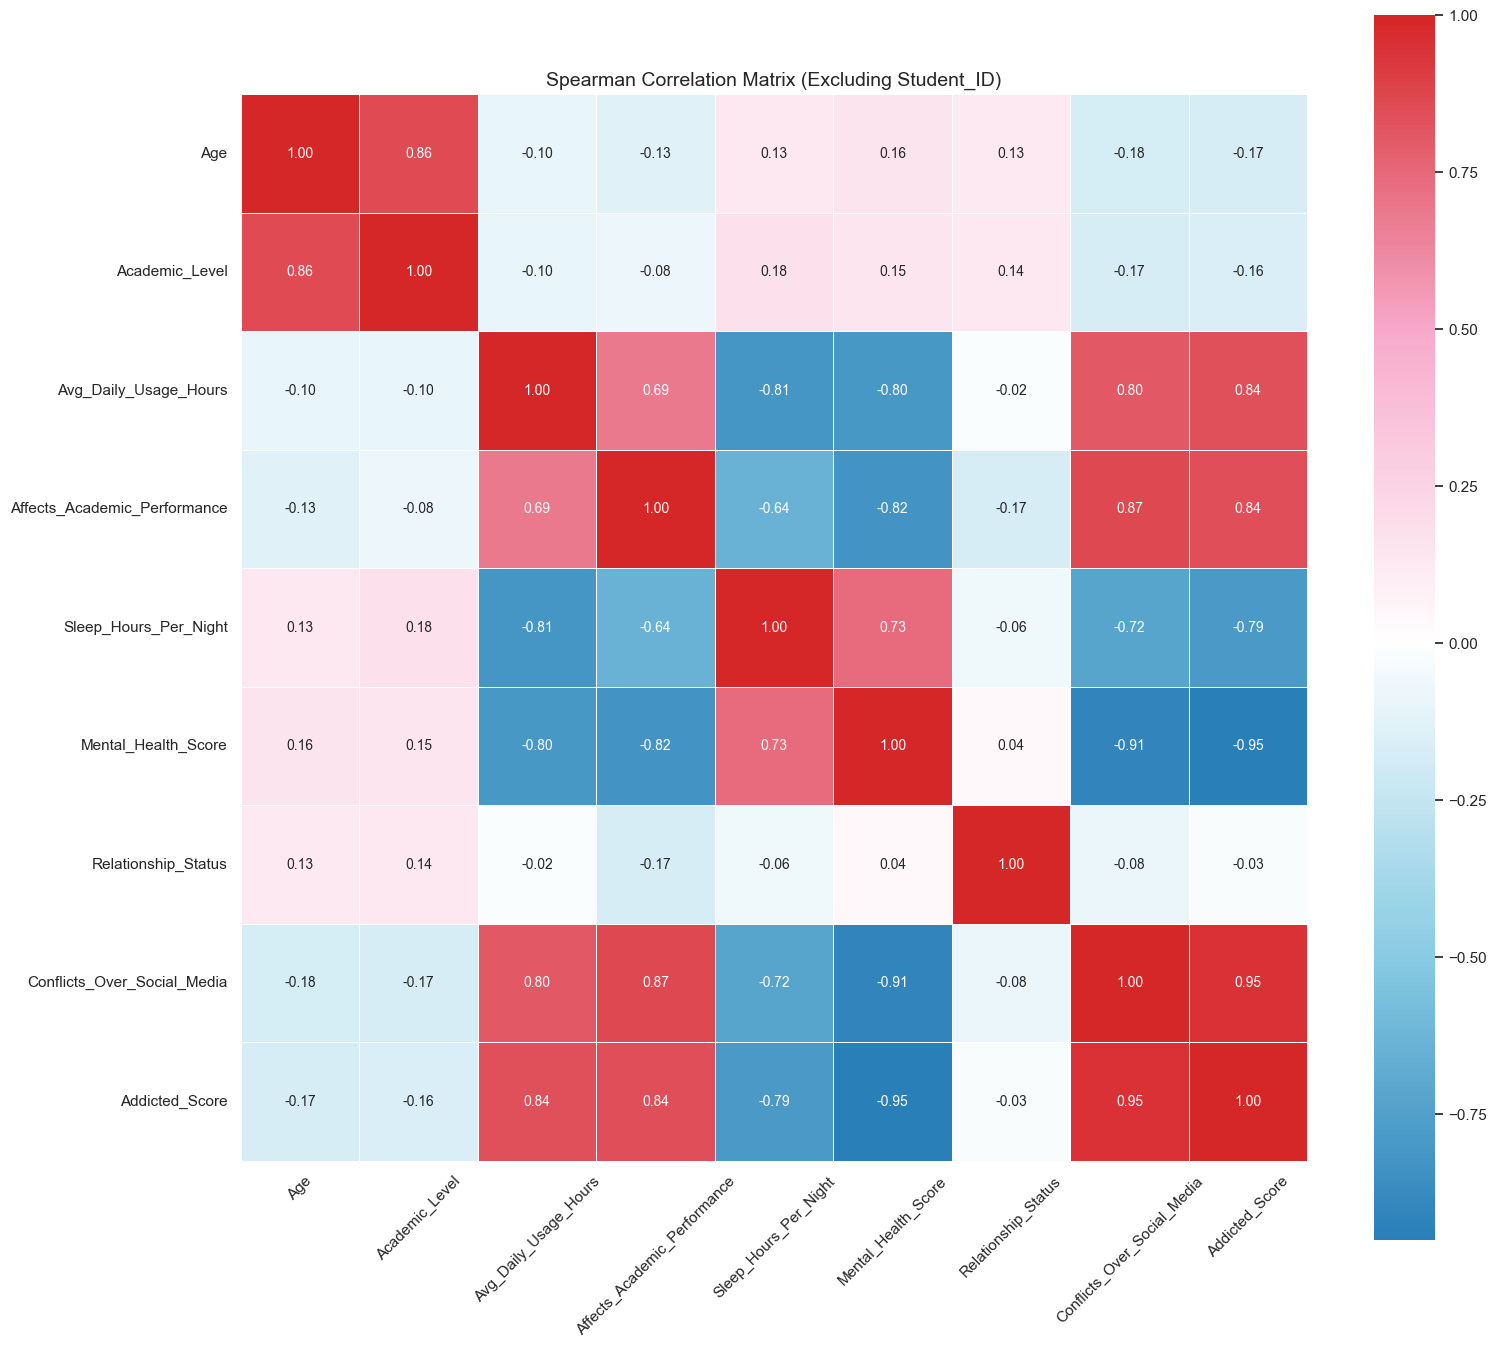

In [694]:
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Drop non-numeric or irrelevant columns before computing correlation
df_corr = st_clean_df.drop(columns=['Student_ID'], errors='ignore')

# Step 2: Compute Spearman correlation (suitable for non-normally distributed or ordinal data)
spearman_corr = df_corr.corr(method='spearman', numeric_only=True)

# Step 3: Create a custom colormap (low = blue, 0 = white, high = red)
custom_cmap = LinearSegmentedColormap.from_list(
    "blue_cyan_white_pink_red",
    ['#1f77b4','#88cbe3', 'white', '#f7aacb', '#d62728'],
    N=256
)

# Step 4: Plot the correlation heatmap with custom colors
plt.figure(figsize=(16, 14))
sns.heatmap(spearman_corr,
            annot=True,           # Show correlation values
            fmt=".2f",            # Format with 2 decimal places
            cmap=custom_cmap,     # Use the custom color map
            center=0,             # Ensure that 0 is mapped to white
            square=True,
            linewidths=0.5,
            annot_kws={"size": 10})

# Step 5: Final plot formatting
plt.title('Spearman Correlation Matrix (Excluding Student_ID)', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Spearman correlation analysis revealed several strong monotonic relationships.**
- `Addicted_Score` showed a very high positive correlation with both `Conflicts_Over_Social_Media` ($\rho = 0.95$) and `Affects_Academic_Performance` ($\rho = 0.84$)
> Indicating that higher addiction levels are associated with more social media-related conflicts and academic difficulties.

- `Mental_Health_Score` was strongly negatively correlated with `Addicted_Score` ($\rho = -0.95$) and `Conflicts_Over_Social_Media` ($\rho = -0.91$), and positively correlated with `Sleep_Hours_Per_Night` ($\rho = 0.73$)
> Suggesting that better sleep is linked to better mental health, while high addiction and social conflicts relate to worse outcomes.

- A moderate negative correlation was observed between `Avg_Daily_Usage_Hours` and `Sleep_Hours_Per_Night` ($\rho = -0.81$).

- `Age` and `Academic_Level` were highly correlated ($\rho = 0.86$)
> Reflecting expected progression. Correlations involving `Relationship_Status` were weak and not meaningful.
___


### 2.1.2 - Cramér’s V Association Matrix of Categorical Variables

Cramér's V is a measure of association between two **categorical variables**, based on the chi-squared statistic. It is suitable for nominal or ordinal variables, and is commonly used when evaluating the strength of relationships in contingency tables (cross-tabulations).

The value of Cramér’s V ranges from 0 to 1:
- 0 indicates no association
- 1 indicates perfect association

It is **symmetric**, meaning $V(x, y) = V(y, x)$.

The formula for Cramér’s V is:

$$
\phi_c = \sqrt{ \frac{\chi^2}{n \cdot (k - 1)} }
$$

Where:
- $\chi^2$ is the chi-squared statistic from the contingency table
- $n$ is the total number of observations
- $k$ is the smaller of (number of rows, number of columns)

In the corrected version (bias-adjusted), adjustments are made for small sample sizes and uneven tables. This is especially useful when dealing with more than 2x2 tables or sparse data.

Cramér's V is particularly helpful in **correlation heatmaps** when exploring categorical variable relationships without assuming any directionality.


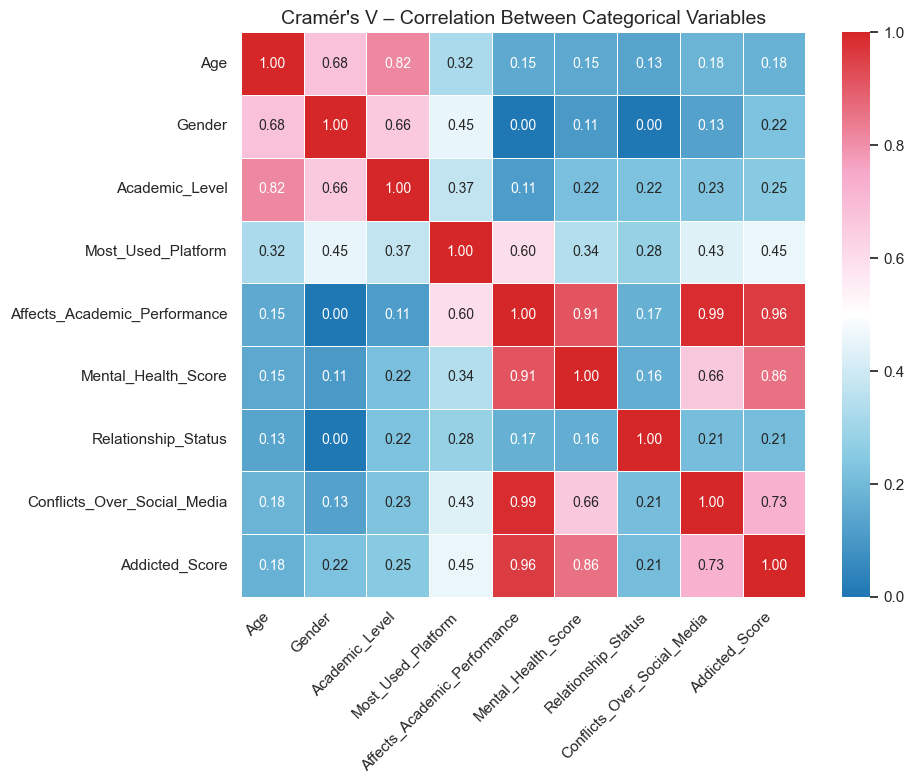

In [695]:
from scipy.stats import chi2_contingency
# Function to compute Cramér's V between all pairs of categorical variables
def cramers_v_matrix(df, cols):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2, _, _, _ = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2_corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
        r_corr = r - ((r - 1)**2)/(n - 1)
        k_corr = k - ((k - 1)**2)/(n - 1)
        return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

    mat = pd.DataFrame(index=cols, columns=cols)

    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                mat.loc[col1, col2] = 1.0
            else:
                mat.loc[col1, col2] = cramers_v(df[col1], df[col2])

    return mat.astype(float)

# Select categorical variables (excluding irrelevant ones like 'Country')
cramer_cols = [
    col for col in categorical_cols
    if col != 'Country' and col in st_clean_df.columns
]

# Compute the Cramér's V correlation matrix
cramer_matrix = cramers_v_matrix(st_clean_df, cramer_cols)

# Define a custom colormap for aesthetic visualization
custom_cmap = LinearSegmentedColormap.from_list(
    "nice_blue_white_red",
    ['#1f77b4', '#88cbe3', '#ffffff', '#f7aacb', '#d62728'],
    N=256
)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix,
            annot=True,
            fmt=".2f",
            cmap=custom_cmap,
            square=True,
            linewidths=0.5,
            annot_kws={"size": 10})

plt.title("Cramér's V – Correlation Between Categorical Variables", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Cramér's V analysis revealed several strong associations between categorical variables.**

**The most prominent relationships were:**

- `Affects_Academic_Performance` and `Conflicts_Over_Social_Media` ($\phi_c = 0.99$)
- `Affects_Academic_Performance` and `Addicted_Score` ($\phi_c = 0.96$)
- `Mental_Health_Score` and `Affects_Academic_Performance` ($\phi_c = 0.91$)
- `Mental_Health_Score` and `Addicted_Score` ($\phi_c = 0.86$)

> **These results suggest that both mental health and academic performance are closely related to addiction and social media conflicts.**

> We also observed high associations among demographic features such as `Age` and `Academic_Level` ($\phi_c = 0.82$), as well as `Age` and `Gender` ($\phi_c = 0.68$), which likely reflect natural educational and population structure.

Other variable pairs showed weak to moderate associations ($\phi_c < 0.45$), and may be of limited interpretive value.


___

### 2.1.3 Ploting Bar plot for Target Variables

#### Cramér's V – Sorted Barplot (Target: Categorical Variable)

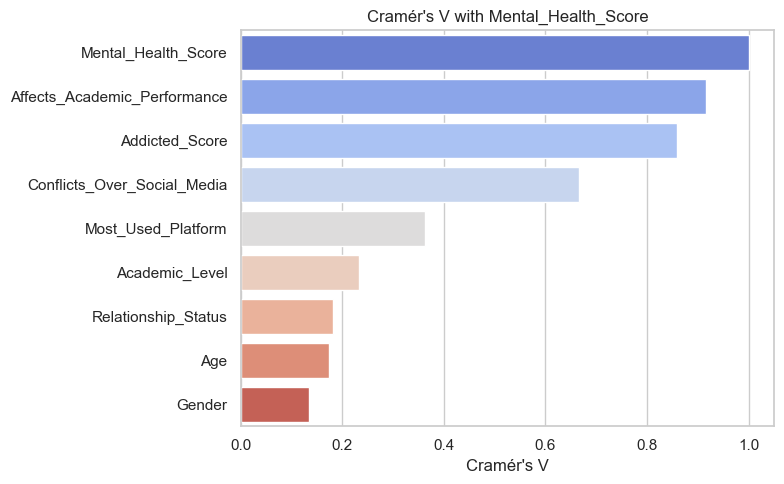

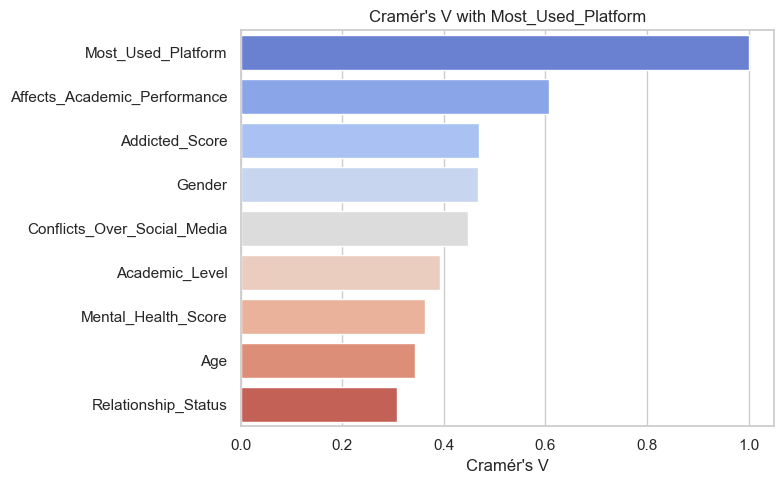

In [696]:
from scipy.stats import chi2_contingency

def plot_cramers_v(v_df, target ,categorical_cols):

    results = []
    for col in categorical_cols:
        try:
            table = pd.crosstab(v_df[target], v_df[col])
            chi2, _, _, _ = chi2_contingency(table)
            n = table.sum().sum()
            r, k = table.shape
            cramers_v = np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
            results.append((col, cramers_v))
        except:
            results.append((col, np.nan))


    cramers_df = pd.DataFrame(results, columns=['Variable', "Cramér's V"])
    cramers_df = cramers_df.dropna().sort_values(by="Cramér's V", ascending=False)


    plt.figure(figsize=(8, 5))
    sns.barplot(x="Cramér's V", y="Variable", data=cramers_df, palette="coolwarm")
    plt.title(f"Cramér's V with {target}")
    plt.xlabel("Cramér's V")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


target = ['Mental_Health_Score','Most_Used_Platform' ]

for tar in target:
    plot_cramers_v(st_clean_df, tar, categorical_cols)

___

#### Spearman Correlation – Sorted Barplot (Target: Numerical/Ordinal Variable)

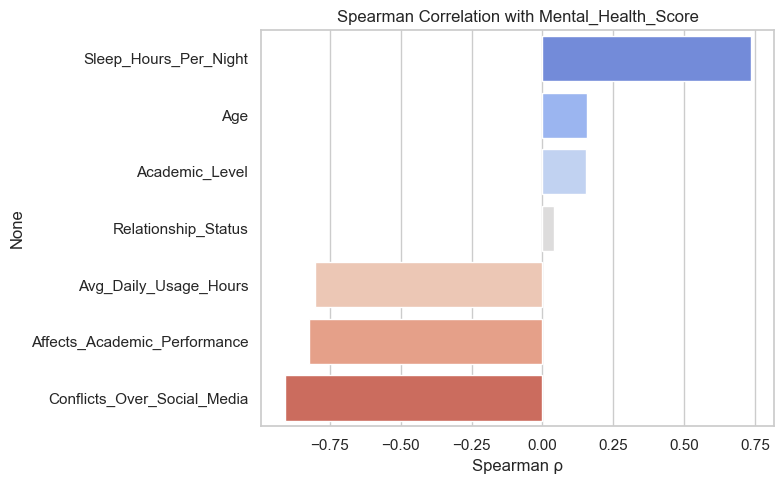

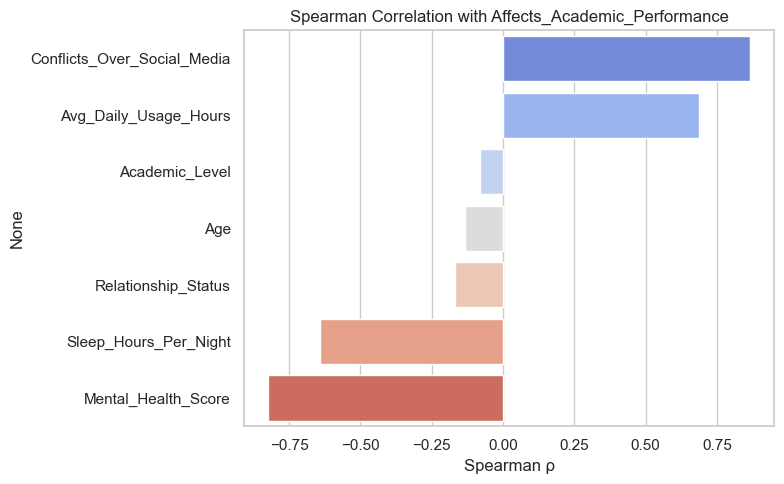

In [697]:
def plot_spearman_with_target(df, target_col, numeric_cols):
    corrs = {}
    for col in numeric_cols:
        if col == target_col:
            continue
        rho = df[[col, target_col]].corr(method='spearman').iloc[0, 1]
        corrs[col] = rho

    spearman_series = pd.Series(corrs, name=f"Spearman with {target_col}")
    spearman_sorted = spearman_series.sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=spearman_sorted.values, y=spearman_sorted.index, palette="coolwarm")
    plt.title(f"Spearman Correlation with {target_col}")
    plt.xlabel("Spearman ρ")
    plt.tight_layout()
    plt.show()

ordinal_cols = ['Academic_Level', 'Relationship_Status', 'Affects_Academic_Performance',
                 'Mental_Health_Score', 'Age', 'Conflicts_Over_Social_Media']


all_rankable_cols = numeric_cols + ordinal_cols
plot_spearman_with_target(st_clean_df, 'Mental_Health_Score', all_rankable_cols)
plot_spearman_with_target(st_clean_df, 'Affects_Academic_Performance', all_rankable_cols)

___

## 2.2 - Academic Performance Analysis

**Focused Analysis: Affects_Academic_Performance**

The variable `Affects_Academic_Performance` serves as the **primary outcome** of interest in this study. It captures whether students perceive that social media usage impacts their academic performance (binary: 0 = No, 1 = Yes).

Throughout the analysis, this variable was used to:

- **Assess correlations** with numeric and ordinal variables using Spearman’s $\rho$.
- **Test group differences** via the Mann–Whitney U test for continuous predictors.
- **Evaluate categorical associations** using Chi-squared and Fisher’s Exact tests.
- **Model predictive relationships** using logistic regression, quantifying the strength and direction of influence for each explanatory variable.

Given its central role, `Affects_Academic_Performance` serves as the lens through which we interpret all relationships in the data.


### 2.2.1 - Correlation Analysis with Academic Performance (Spearman)

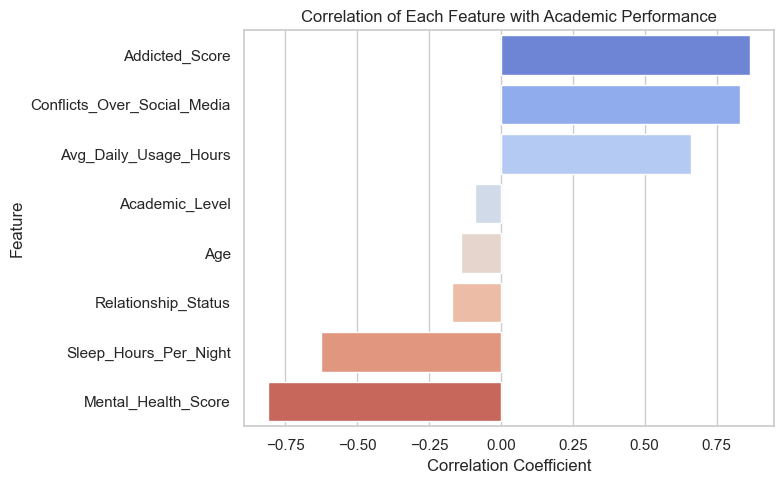

Addicted_Score                 0.866049
Conflicts_Over_Social_Media    0.832030
Avg_Daily_Usage_Hours          0.661474
Academic_Level                -0.091373
Age                           -0.137140
Relationship_Status           -0.171146
Sleep_Hours_Per_Night         -0.625373
Mental_Health_Score           -0.808921
Name: Affects_Academic_Performance, dtype: float64


In [698]:
correlations = st_clean_df.corr(numeric_only=True)['Affects_Academic_Performance'].sort_values(ascending=False)

correlations = correlations.drop('Affects_Academic_Performance', errors='ignore')
correlations = correlations.drop('Student_ID', errors='ignore')


Academic_Performance_correlations_df = correlations.reset_index()
Academic_Performance_correlations_df.columns = ['Feature', 'Correlation with Academic Performance']


plt.figure(figsize=(8, 5))
sns.barplot(x='Correlation with Academic Performance', y='Feature', data=Academic_Performance_correlations_df, palette='coolwarm')
plt.title('Correlation of Each Feature with Academic Performance')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(correlations)

### 2.2.2 – Comparison of Numerical Features by Academic Performance Impact (Violinplots & Mann–Whitney U test)
 2.2.2 – Numerical Features by Academic Performance Impact (Violinplots, Mann–Whitney U Test)


The Mann–Whitney U test is a non-parametric statistical test used to determine whether there is a significant difference between two independent groups on a continuous or ordinal outcome. It is an alternative to the independent samples t-test when the assumption of normality is not met.

**Hypotheses:**
- **Null hypothesis ($H_0$):** The distributions of the two groups are equal.
- **Alternative hypothesis ($H_1$):** The distributions of the two groups differ (in location).

**Assumptions:**
- The two samples are independent.
- The dependent variable is ordinal or continuous.
- The distributions have the same shape (for the test to compare medians meaningfully).

**Test Statistic:**
The Mann–Whitney U statistic is defined as:

$$
U = n_1 n_2 + \frac{n_1(n_1 + 1)}{2} - R_1
$$

Where:
- $n_1$, $n_2$ are the sample sizes of the two groups.
- $R_1$ is the sum of ranks in group 1 (after combining and ranking all values).

A smaller U value indicates greater separation between the groups. A corresponding p-value is used to assess statistical significance.


**What is $R$ (Rank)?**  
In non-parametric tests, **raw values are replaced with their ranks** across the full dataset.  
For example, the lowest value gets rank 1, the second lowest rank 2, and so on.  
If there are ties (equal values), the average rank is used.  
These ranks form the basis for all calculations in Kruskal–Wallis and Dunn's tests, focusing on the **relative ordering** of values rather than their raw magnitude.

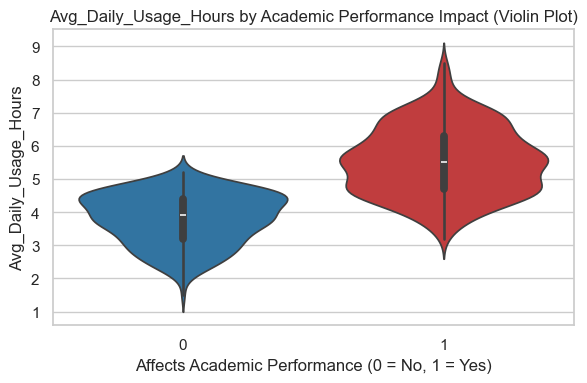

Avg_Daily_Usage_Hours — Mann–Whitney p-value = 0.0000 → Significant


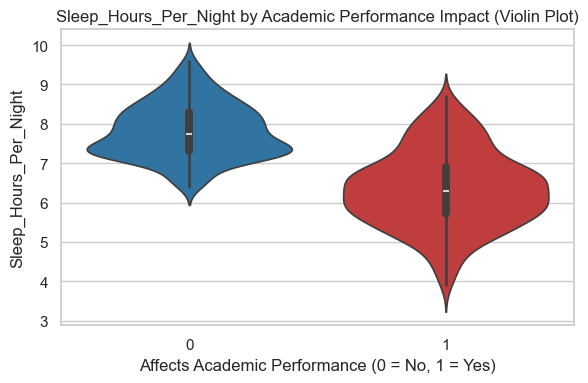

Sleep_Hours_Per_Night — Mann–Whitney p-value = 0.0000 → Significant


In [699]:
from scipy.stats import mannwhitneyu

for col in numeric_cols:
    # Filter valid data from the original data 
    df_filtered = df[[col, 'Affects_Academic_Performance']].dropna()
    group0 = df_filtered[df_filtered['Affects_Academic_Performance'] == 0][col]
    group1 = df_filtered[df_filtered['Affects_Academic_Performance'] == 1][col]

    # Mann–Whitney U test
    stat, p_val = mannwhitneyu(group0, group1, alternative='two-sided')

    # Violin plot
    plt.figure(figsize=(6, 4))
    sns.violinplot(
        x='Affects_Academic_Performance',
        y=col,
        data=df_filtered,
        palette={'0': '#1f77b4', '1': '#d62728'}  # Manual color mapping: 0 → blue, 1 → red
    )
    plt.title(f'{col} by Academic Performance Impact (Violin Plot)')
    plt.xlabel('Affects Academic Performance (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Result output
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{col} — Mann–Whitney p-value = {p_val:.4f} → {significance}")


**Summary of Findings (Based on Original Data)**

The Mann–Whitney U test results indicate significant differences in distributions between students who report that social media affects their academic performance (group 1) and those who do not (group 0), for both:

* **Sleep Hours per Night**: Students whose academic performance is affected tend to **sleep less** (p-value = 0.0000).
* **Average Daily Usage Hours**: Those affected spend **more time on social media daily** (p-value = 0.0000).

> These results are **consistent** with those obtained using normalized data, reinforcing the robustness of the findings. The use of original values also enhances the **interpretability** of the violin plots.

___


### 2.2.3 – Statistical Association Between Categorical Features and Academic Performance (Chi-squared Tests)
2.2.3 – Association Between Categorical Features and Academic Performance (Chi-Squared Test)

The association between the binary variable `Affects_Academic_Performance` and multiple categorical predictors was assessed using either **Chi-squared test** or **Fisher’s Exact Test**, depending on the structure of the contingency table.

If the contingency table is $2 \times 2$, Fisher’s Exact Test is used for its accuracy with small sample sizes. Otherwise, the Chi-squared test is applied.

The **null hypothesis** is that the feature and the binary target are statistically independent:

- $H_0$: The categorical variable and academic performance are independent  
- $H_1$: There is a dependency between the categorical variable and academic performance

The **Chi-squared statistic** is given by:  
$$
\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$  
where $O_{ij}$ is the observed frequency and $E_{ij}$ is the expected frequency under $H_0$.

A result is considered **statistically significant** if the p-value is below 0.05.  
For significant features, bar plots show the **proportion of students** reporting academic impact $(=1)$ within each category.


,Categorical Variable,Test Used,p-value,Significant (p < 0.05)
6,Conflicts_Over_Social_Media,Chi-squared Test,2.470502e-147,YES
7,Addicted_Score,Chi-squared Test,6.885766e-137,YES
4,Mental_Health_Score,Chi-squared Test,2.043748e-125,YES
3,Most_Used_Platform,Chi-squared Test,1.917345e-49,YES
5,Relationship_Status,Chi-squared Test,1.168651e-05,YES
0,Age,Chi-squared Test,1.334340e-03,YES
2,Academic_Level,Chi-squared Test,4.533050e-03,YES
1,Gender,Fisher’s Exact Test,5.301170e-01,NO


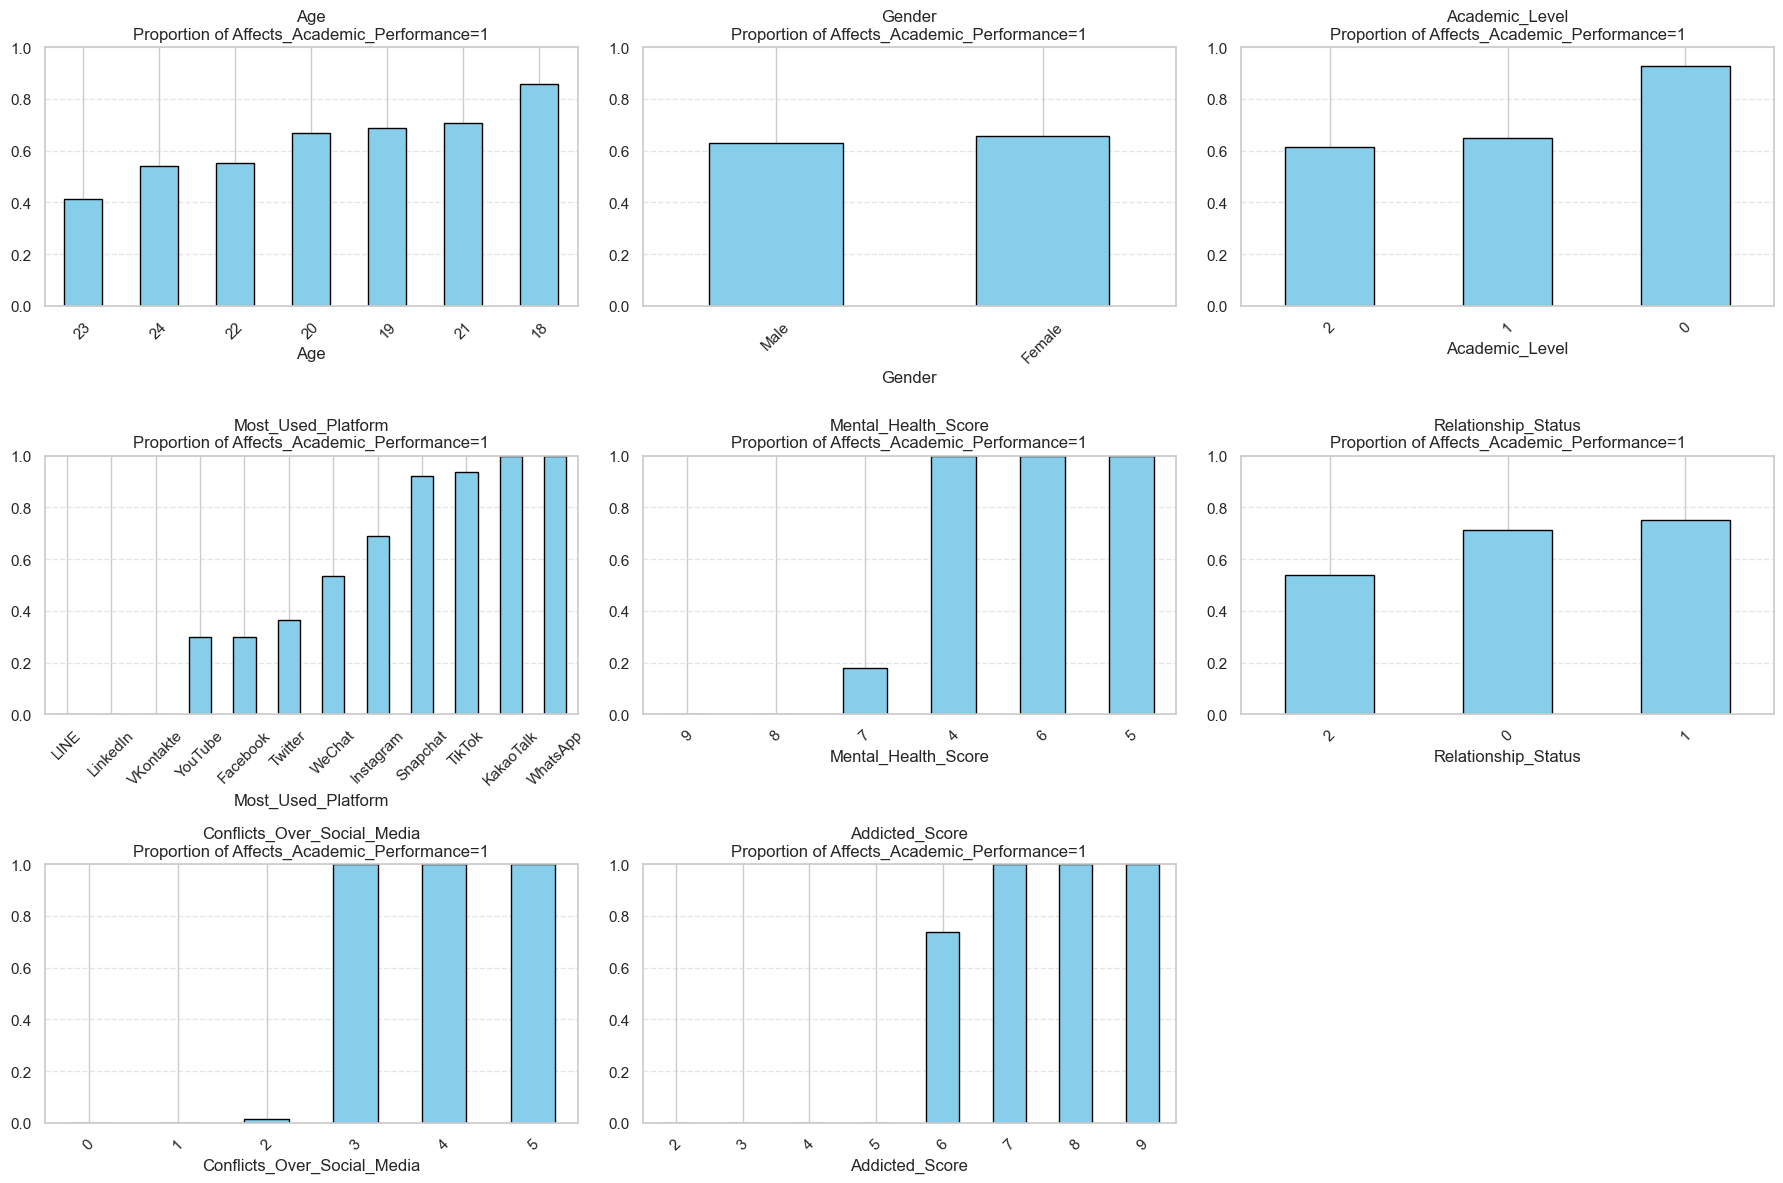

In [700]:
from scipy.stats import chi2_contingency, fisher_exact

def categorical_tests_with_binary_target(df, target_col, categorical_cols):
    results = []
    valid_cols = []

    for col in categorical_cols:
        if col == target_col or col not in df.columns:
            continue

        temp_df = df[[col, target_col]].dropna()
        contingency = pd.crosstab(temp_df[col], temp_df[target_col])

        if contingency.shape[0] > 1 and contingency.shape[1] == 2:
            # Choose between Fisher or Chi-squared
            if contingency.shape == (2, 2):
                stat, p_val = fisher_exact(contingency.values)
                test_used = "Fisher’s Exact Test"
            else:
                stat, p_val, _, _ = chi2_contingency(contingency)
                test_used = "Chi-squared Test"

            results.append({
                'Categorical Variable': col,
                'Test Used': test_used,
                'p-value': p_val,
                'Significant (p < 0.05)': 'YES' if p_val < 0.05 else 'NO'
            })
            valid_cols.append(col)

    results_df = pd.DataFrame(results).sort_values(by='p-value')
    display(results_df)

    # Bar plots for tested features
    n_cols = 3
    n_rows = int(np.ceil(len(valid_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    for idx, col in enumerate(valid_cols):
        ax = axes[idx]
        temp_df = df[[col, target_col]].dropna()
        prop_df = temp_df.groupby(col)[target_col].mean().sort_values()

        prop_df.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title(f'{col}\nProportion of {target_col}=1')
        ax.set_xlabel(col)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results_df

# Run test for categorical features vs binary target
chi2_fisher_results = categorical_tests_with_binary_target(
    df=st_clean_df,
    target_col='Affects_Academic_Performance',
    categorical_cols=categorical_cols
)


Test Summary

This analysis applied **Chi-squared tests** (and **Fisher's Exact Test** for 2×2 tables) to examine the association between categorical variables and the binary outcome variable `Affects_Academic_Performance`.

- **Significance:**  
  Out of 8 categorical variables, **7 showed statistically significant associations** with the outcome (p < 0.05).  
  Only **Gender** was **not significant** (p ≈ 0.53, Fisher’s Exact Test).


Insights from Proportion Bar Plots

The bar plots display the **proportion of students who reported academic impact** (`=1`) across the different levels of each categorical variable:

- 🔹 **Addicted_Score**, **Conflicts_Over_Social_Media**, and **Mental_Health_Score** show strong positive associations: as levels of addiction or psychological distress increase, so does the likelihood of reporting academic impact.
- 🔹 **Most_Used_Platform**: Platforms like **TikTok**, **Snapchat**, and **WhatsApp** are linked with higher proportions of academic impact, compared to platforms like **LINE** and **LinkedIn**.
- 🔹 **Relationship_Status**: Being in a relationship or single is associated with a higher likelihood of reported academic impact compared to other statuses.
- 🔹 **Academic_Level** and **Age**: Younger students and those in lower academic levels tend to report greater academic impact.


Key Takeaway

The strongest predictors of academic performance impact appear to be **emotional and behavioral factors**, such as mental health, social media conflict, and addictive behaviors.  
Demographic variables like platform usage, relationship status, and academic level offer additional context but with lower effect size.
___


### 2.2.4 - Logistic Regression Analysis of Academic Performance Impact
2.2.4 – Logistic Regression: Predicting Academic Performance Impact

This section applies univariate logistic regression to assess the relationship between each numerical feature and the binary target variable `Affects_Academic_Performance`.

The goal is to evaluate how well each individual feature can predict whether a student reports an academic impact. The logistic model estimates the probability of the positive class using the function:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
$$

where $\beta_0$ is the intercept and $\beta_1$ is the coefficient for predictor $X$.

Model fit is assessed using pseudo-$R^2$, defined as:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{p}_i)^2}{\sum (y_i - \bar{y})^2}
$$

This statistic approximates the proportion of variance in the binary outcome explained by the logistic model.

The output includes plots showing observed data points and the fitted logistic curve for each predictor, along with a summary table reporting the feature name, coefficient, intercept, and pseudo-$R^2$.


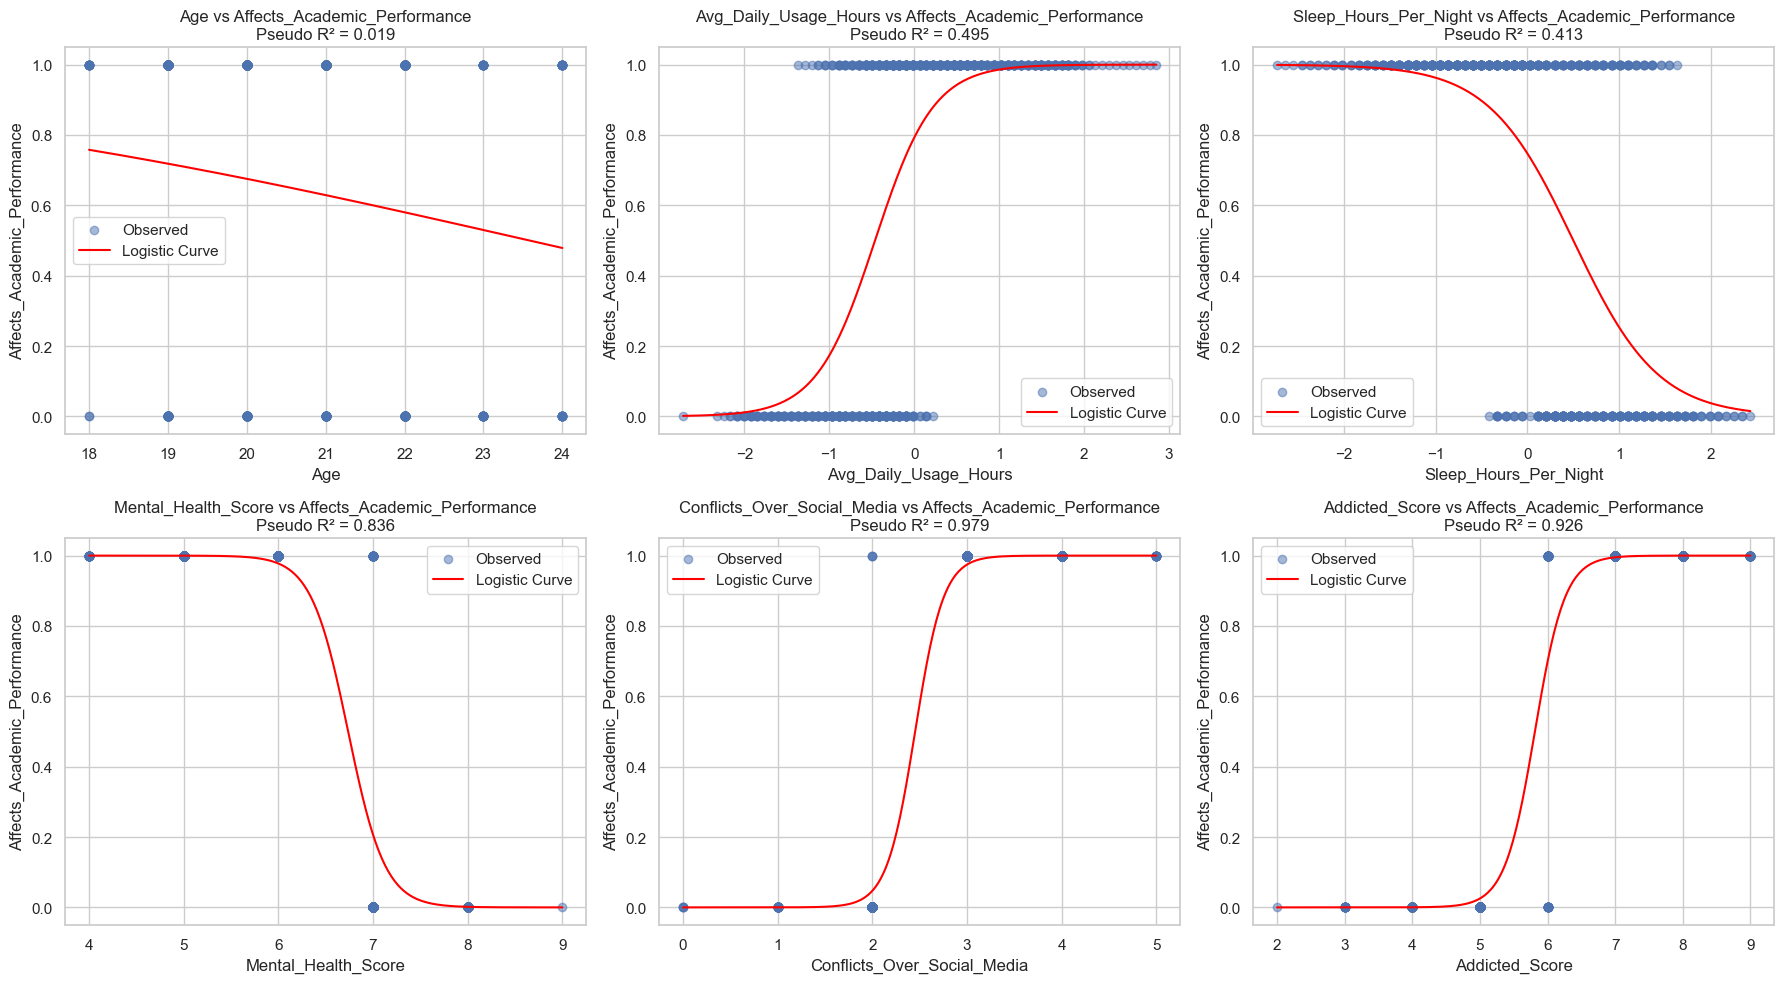

,Feature,Coefficient,Intercept,Pseudo R²
0,Conflicts_Over_Social_Media,6.645750,-16.294807,0.979359
1,Addicted_Score,4.493427,-26.123574,0.925945
2,Mental_Health_Score,-5.118804,34.486117,0.836428
3,Avg_Daily_Usage_Hours,2.904133,1.339121,0.495299
4,Sleep_Hours_Per_Night,-2.169325,1.082335,0.412651
5,Age,-0.204323,4.818655,0.019107


In [701]:
from sklearn.linear_model import LogisticRegression

# Define target variable
target_column = "Affects_Academic_Performance"

# Columns to ignore
ignore_columns = ['Student_ID', 'Country', target_column]

# Select only relevant numerical features
features = [
    col for col in st_clean_df.columns
    if col not in ignore_columns and
       st_clean_df[col].nunique() > 5 and
       st_clean_df[col].dtype in ['float64', 'int64']
]

# Set up the subplot grid
n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Store logistic regression results
results = []

for i, column in enumerate(features):
    X = st_clean_df[[column]].dropna()
    y = st_clean_df.loc[X.index, target_column]

    # Skip if the target is not binary (0/1)
    if y.nunique() != 2:
        continue

    # Fit logistic regression
    model = LogisticRegression()
    model.fit(X, y)
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Compute pseudo R² (based on residual sum of squares)
    pseudo_r2 = 1 - (np.sum((y - y_pred_proba) ** 2) / np.sum((y - y.mean()) ** 2))

    # Generate logistic curve
    x_vals = np.linspace(X[column].min(), X[column].max(), 300).reshape(-1, 1)
    y_vals = model.predict_proba(x_vals)[:, 1]

    # Plot scatter and curve
    ax = axes[i]
    ax.scatter(X, y, label='Observed', alpha=0.5)
    ax.plot(x_vals, y_vals, color='red', label='Logistic Curve')
    ax.set_title(f'{column} vs {target_column}\nPseudo R² = {pseudo_r2:.3f}')
    ax.set_xlabel(column)
    ax.set_ylabel(target_column)
    ax.legend()
    ax.grid(True)

    # Store result
    results.append({
        'Feature': column,
        'Coefficient': model.coef_[0][0],
        'Intercept': model.intercept_[0],
        'Pseudo R²': pseudo_r2
    })

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create and display summary table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Pseudo R²', ascending=False).reset_index(drop=True)
display(results_df)


**Logistic Regression Results Summary**

A series of univariate logistic regression models were fitted to examine the relationship between each numeric predictor and the binary target variable, `Affects_Academic_Performance`. For each model, we report the estimated coefficient, intercept, and pseudo-$R^2$.

The logistic model used is:

$$
P(Y = 1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
$$

where:
- $Y$ is the binary outcome (`Affects_Academic_Performance`)
- $X$ is the explanatory variable
- $\beta_0$ is the intercept
- $\beta_1$ is the slope (coefficient)

**Key Findings:**
- `Conflicts_Over_Social_Media` showed the strongest predictive power ($R^2 = 0.979$), with a sharp increase in predicted probability as scores increase.
- `Addicted_Score` and `Mental_Health_Score` also had strong associations ($R^2 = 0.926$, $0.836$ respectively).
- `Avg_Daily_Usage_Hours` and `Sleep_Hours_Per_Night` were moderately predictive ($R^2 \approx 0.41$–$0.49$).
- `Age` had very weak explanatory power ($R^2 = 0.019$), suggesting it is not a strong standalone predictor in this context.

> These results align visually with the fitted logistic curves, where steeper transitions and better separation of outcome classes correspond to higher pseudo-$R^2$ values.
___

## 2.3 - Mental Health Analysis

**Focused Analysis: Mental Health Score**


The variable `Mental_Health_Score` has emerged as one of the strongest predictors of academic performance impact. In previous analyses:

- It showed a **strong negative Spearman correlation** with `Affects_Academic_Performance`, suggesting that higher mental health scores are associated with a lower likelihood of academic disruption.
- It was **highly significant** in the Mann–Whitney test, indicating a notable distributional difference between students affected and unaffected academically.
- In the logistic regression model, `Mental_Health_Score` yielded a **pseudo-$R^2$ of 0.836**, highlighting its strong explanatory power in predicting the binary outcome.

Given its statistical relevance and practical importance, we now proceed with a deeper analysis of this variable.


### 2.3.1 - Correlation Analysis with Mental Health (Spearman)

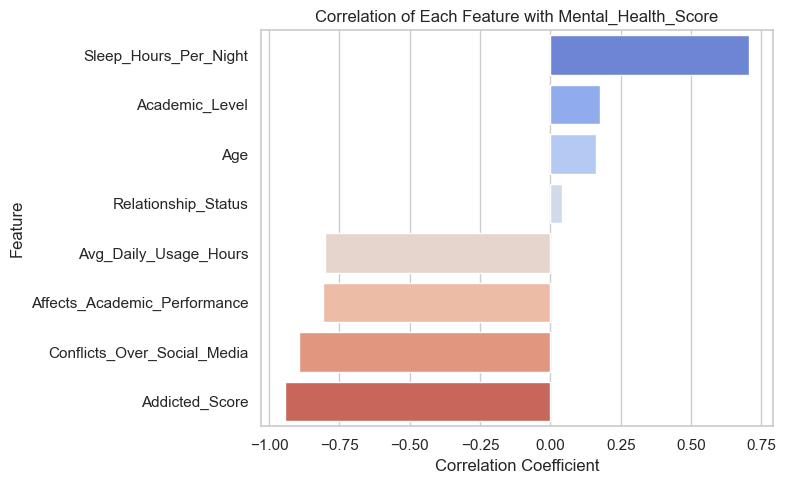

Sleep_Hours_Per_Night           0.707439
Academic_Level                  0.175512
Age                             0.160278
Relationship_Status             0.041892
Avg_Daily_Usage_Hours          -0.801058
Affects_Academic_Performance   -0.808921
Conflicts_Over_Social_Media    -0.893572
Addicted_Score                 -0.945051
Name: Mental_Health_Score, dtype: float64


In [702]:
correlations = st_clean_df.corr(numeric_only=True)['Mental_Health_Score'].sort_values(ascending=False)

correlations = correlations.drop('Mental_Health_Score', errors='ignore')
correlations = correlations.drop('Student_ID', errors='ignore')


Mental_Health_correlations_df = correlations.reset_index()
Mental_Health_correlations_df.columns = ['Feature', 'Correlation with Mental_Health_Score']


plt.figure(figsize=(8, 5))
sns.barplot(x='Correlation with Mental_Health_Score', y='Feature', data=Mental_Health_correlations_df, palette='coolwarm')
plt.title('Correlation of Each Feature with Mental_Health_Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(correlations)

###  2.3.2 – Comparison of Numerical Features Across Mental Health Levels (Kruskal–Wallis Tests)
### 2.3.2 – Numerical Features Across Mental Health Levels (Kruskal–Wallis Test)

**We will check which group has values**

In [703]:
print("Unique values in Mental_Health_Score:")
print(st_clean_df['Mental_Health_Score'].value_counts().sort_index())

Unique values in Mental_Health_Score:
Mental_Health_Score
4     29
5    173
6    219
7    178
8    105
9      1
Name: count, dtype: int64


> We will run the test only according to the groups that have more then one value - grops 4-8

We assess whether the distributions of numerical features significantly differ across levels of mental health scores using the **Kruskal–Wallis H test**, a non-parametric alternative to one-way ANOVA. This test does not assume normality and is suitable when comparing more than two independent groups.

The null hypothesis ($H_0$) states that all groups have the same distribution:  
$H_0$: The distribution of the variable is the same across mental health levels  
$H_1$: At least one group differs significantly

The Kruskal–Wallis test statistic is computed as:  
$$H = \frac{12}{N(N+1)} \sum_{i=1}^{k} n_i (R_i - \bar{R})^2$$  
Where:  
- $N$ = total number of observations  
- $n_i$ = number of observations in group $i$  
- $R_i$ = average rank of group $i$  
- $\bar{R}$ = overall average rank

A significant p-value ($p < 0.05$) suggests that at least one mental health group exhibits a different distribution for the given numerical variable.

We visualize the results using both boxplots and violin plots to provide a clear comparison across mental health levels.


['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night']


,Numeric Variable,p-value,Significant (p < 0.05)
0,Avg_Daily_Usage_Hours,1.203478e-97,YES
1,Sleep_Hours_Per_Night,1.078724e-83,YES


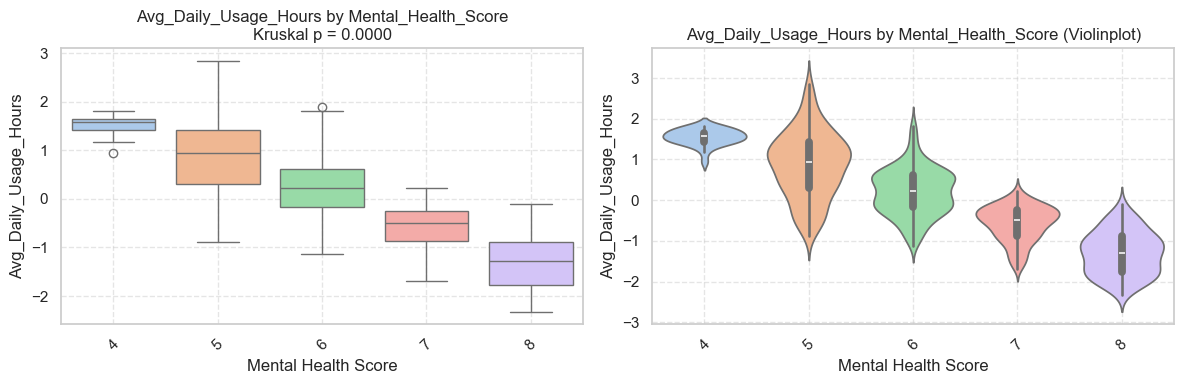

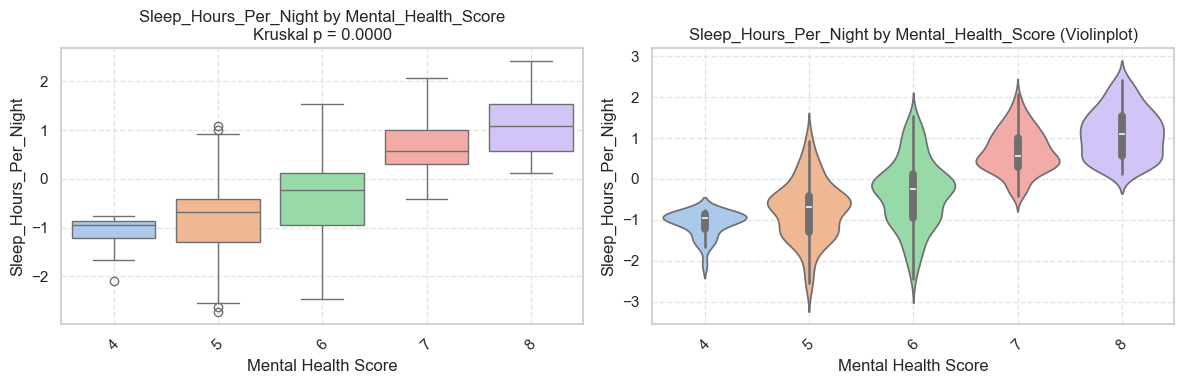

In [704]:
from scipy.stats import kruskal

def kruskal_vs_mh_category(df, mh_cat_col, numeric_cols, min_group_size=2):
    results = []

    # Step 1: Filter out mental health categories with too few observations
    group_sizes = df[mh_cat_col].value_counts()
    valid_groups = group_sizes[group_sizes >= min_group_size].index
    filtered_df = df[df[mh_cat_col].isin(valid_groups)]

    # Step 2: Perform Kruskal-Wallis test for each numeric variable
    for col in numeric_cols:
        groups = [g[col].dropna() for _, g in filtered_df.groupby(mh_cat_col)]

        if len(groups) >= 2:
            stat, p = kruskal(*groups)
            results.append({
                'Numeric Variable': col,
                'p-value': p,
                'Significant (p < 0.05)': 'YES' if p < 0.05 else 'NO'
            })

    if not results:
        print("No valid variables passed Kruskal-Wallis conditions.")
        return pd.DataFrame()

    results_df = pd.DataFrame(results).sort_values(by='p-value')
    display(results_df)

    # Step 3: Plot boxplot and violin plot for each variable
    for _, row in results_df.iterrows():
        col = row['Numeric Variable']
        p_val = row['p-value']

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(x=mh_cat_col, y=col, data=filtered_df, ax=axes[0], palette="pastel")
        axes[0].set_title(f'{col} by {mh_cat_col}\nKruskal p = {p_val:.4f}')

        sns.violinplot(x=mh_cat_col, y=col, data=filtered_df, ax=axes[1], palette="pastel")
        axes[1].set_title(f'{col} by {mh_cat_col} (Violinplot)')

        for ax in axes:
            ax.set_xlabel('Mental Health Score')
            ax.set_ylabel(col)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    return results_df

# Example usage
print(numeric_cols)
kruskal_results = kruskal_vs_mh_category(
    df=st_clean_df,
    mh_cat_col='Mental_Health_Score',
    numeric_cols=numeric_cols
)


The Kruskal–Wallis tests revealed statistically significant differences in both `Avg_Daily_Usage_Hours` and `Sleep_Hours_Per_Night` across levels of the `Mental_Health_Score` (both p-values ≪ 0.001). Visualizations clearly demonstrate opposing trends:

- As `Mental_Health_Score` improves (i.e., higher scores), **daily usage hours decrease**, indicating reduced screen time among mentally healthier participants.
- Conversely, **sleep hours increase** with higher mental health scores, suggesting better sleep habits are associated with better mental well-being.

> These inverse patterns reinforce the hypothesis that screen time and sleep behavior are key correlates of mental health.
___

### 2.3.3 - Statistical Association Between Categorical Features and Mental Health Score (Kruskal-Wallis Tests)


To further explore how categorical features relate to students' mental health, we applied the **Kruskal–Wallis H test**. This non-parametric method tests whether samples from three or more groups originate from the same distribution, without assuming normality or equal variances — making it appropriate for comparing mental health scores across multiple categories.

Given that `Mental_Health_Score` is treated as a continuous dependent variable and the explanatory variables are categorical, Kruskal–Wallis enables us to assess whether different group levels (e.g., relationship status, academic level) are associated with statistically significant differences in mental health.

The null hypothesis is:
$$
H_0: \text{The distributions of mental health scores are identical across all groups.}
$$

The alternative hypothesis is:
$$
H_1: \text{At least one group differs significantly.}
$$

For each categorical feature, we report the $p$-value from the Kruskal–Wallis test and visualize the score distributions using boxplots arranged in a clean grid. This allows for a quick and intuitive comparison across all variables tested.


,Categorical Variable,Kruskal-Wallis p-value,Significant (p < 0.05)
6,Conflicts_Over_Social_Media,5.222660e-124,YES
4,Affects_Academic_Performance,1.056975e-105,YES
3,Most_Used_Platform,7.261036e-34,YES
2,Academic_Level,1.184580e-08,YES
0,Age,6.627368e-05,YES
5,Relationship_Status,1.266223e-01,NO
1,Gender,2.303802e-01,NO


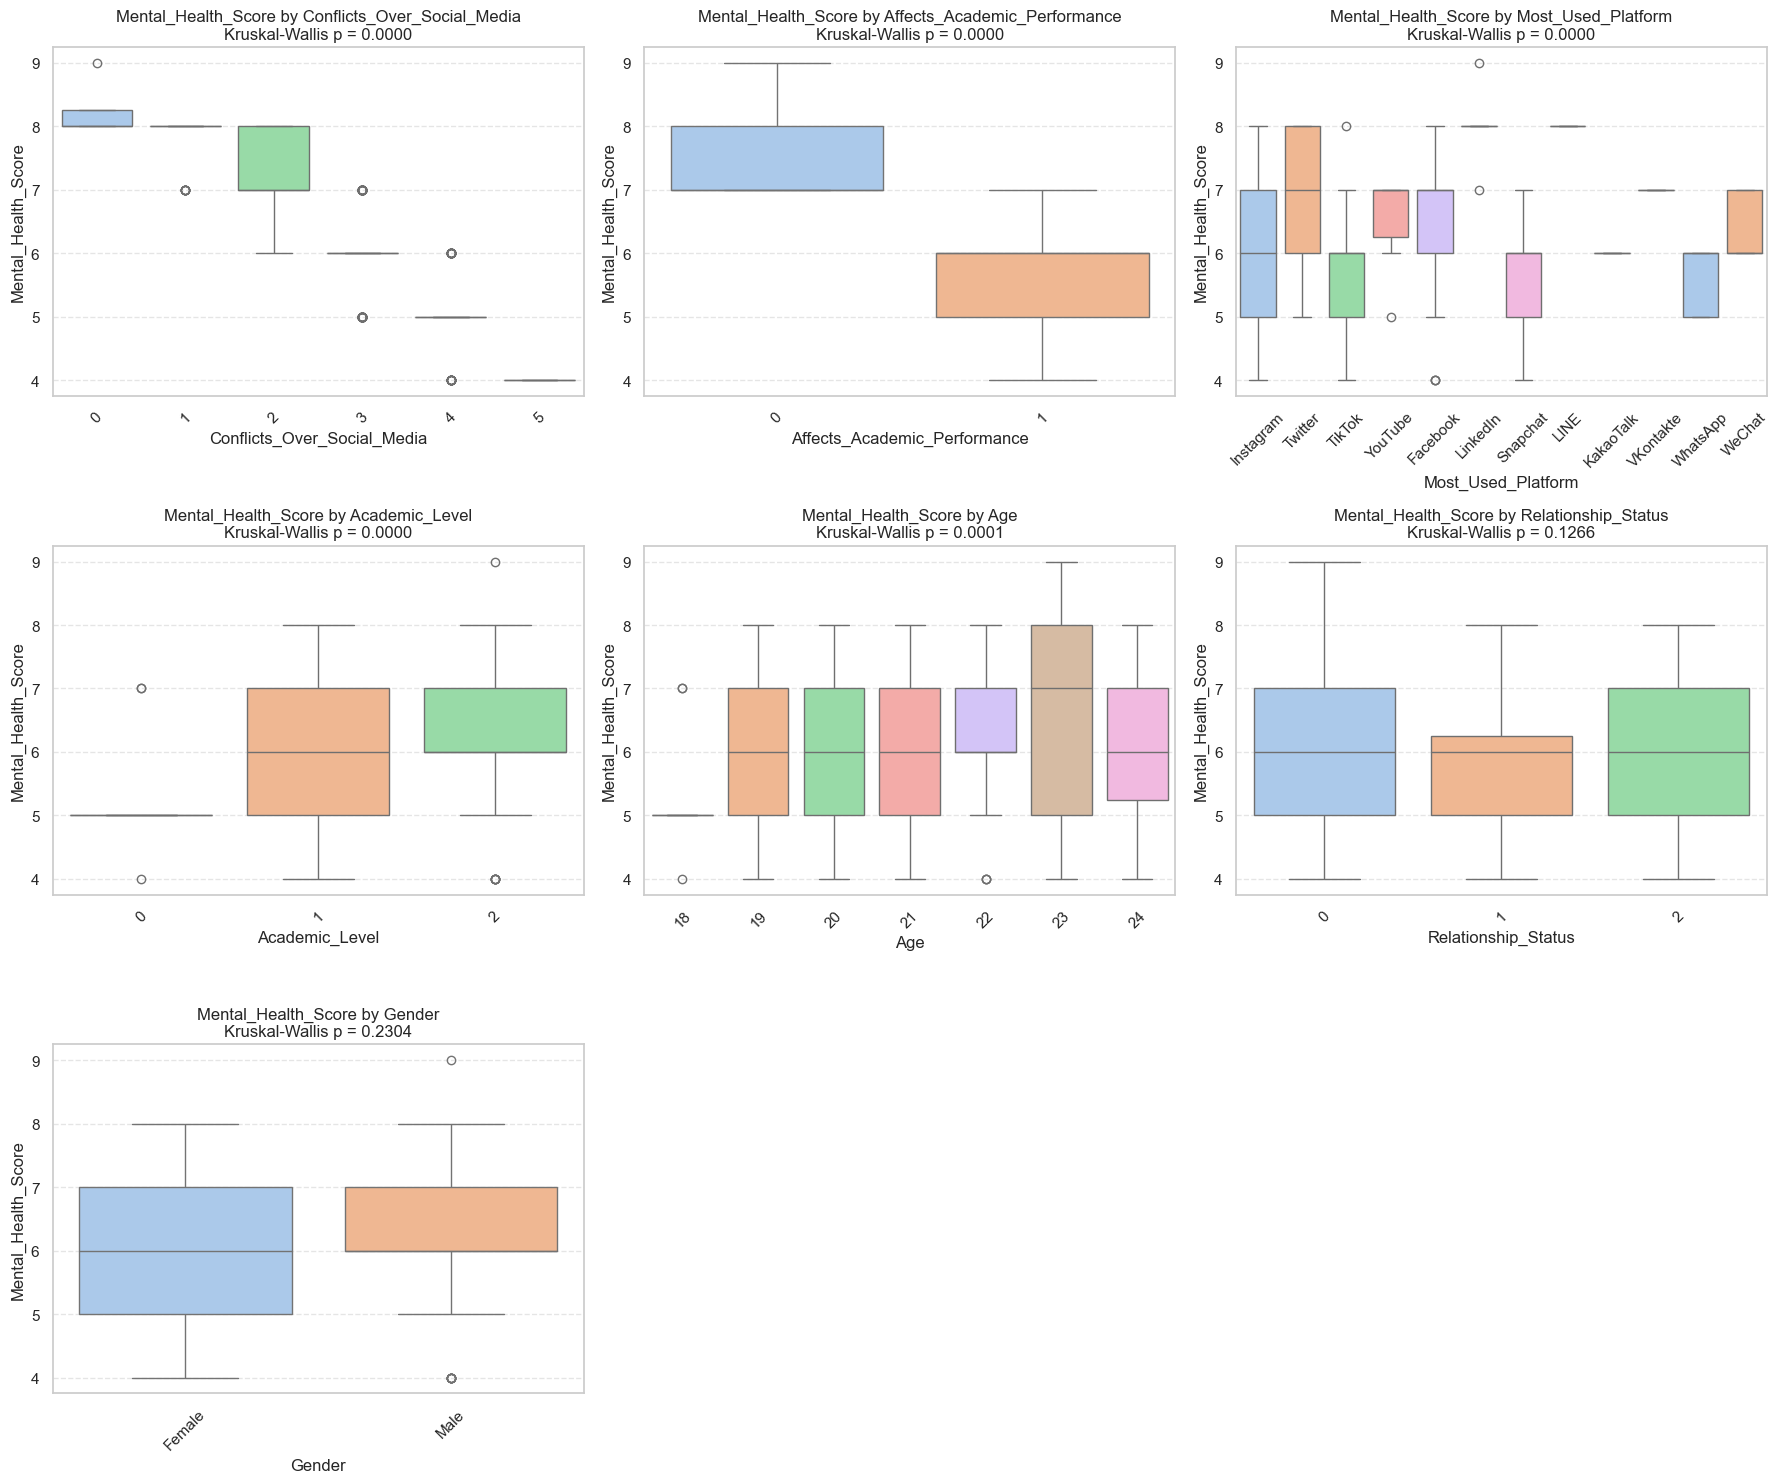

In [705]:
def kruskal_by_category(df, target_col, categorical_cols):
    """
    Performs Kruskal–Wallis tests to assess whether the distribution of a numeric target 
    differs significantly across levels of multiple categorical variables.
    Also plots boxplots for each tested feature.
    """

    results = []

    # Loop through each categorical feature
    for cat in categorical_cols:
        # Group target variable by the current categorical column
        groups = [group[target_col].dropna() for _, group in df.groupby(cat)]
        if len(groups) >= 2 and all(len(g) > 1 for g in groups):
            stat, p = kruskal(*groups)
            results.append({
                'Categorical Variable': cat,
                'Kruskal-Wallis p-value': p,
                'Significant (p < 0.05)': 'YES' if p < 0.05 else 'NO'
            })

    # Create summary DataFrame
    results_df = pd.DataFrame(results).sort_values(by='Kruskal-Wallis p-value')
    display(results_df)

    # Grid layout for plots
    n = len(results_df)
    n_cols = 3
    n_rows = int(np.ceil(n / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    # Plot boxplots
    for i, row in enumerate(results_df.itertuples()):
        col = row._1  # Categorical Variable
        p_val = row._2  # p-value

        sns.boxplot(x=col, y=target_col, data=df, palette="pastel", ax=axes[i])
        axes[i].set_title(f'{target_col} by {col}\nKruskal-Wallis p = {p_val:.4f}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target_col)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return results_df

# Run the test
kruskal_results = kruskal_by_category(
    df=st_clean_df,
    target_col='Mental_Health_Score',
    categorical_cols=categorical_cols
)


The Kruskal-Wallis analysis evaluated whether **Mental_Health_Score** distributions differ across categories of various categorical variables.

The test revealed statistically significant differences ($p < 0.05$) for:

- **Conflicts_Over_Social_Media** ($p < 10^{-100}$)
- **Affects_Academic_Performance** ($p < 10^{-100}$)
- **Most_Used_Platform** ($p \approx 7.26 \times 10^{-34}$)
- **Academic_Level** ($p \approx 1.18 \times 10^{-8}$)
- **Age** ($p \approx 6.62 \times 10^{-5}$)

In contrast, no significant effect was observed for:
- **Relationship_Status** ($p = 0.1266$)
- **Gender** ($p = 0.2304$)

> These results suggest that several demographic and behavioral factors are associated with differing levels of reported mental health, particularly usage patterns and academic-related variables.
___

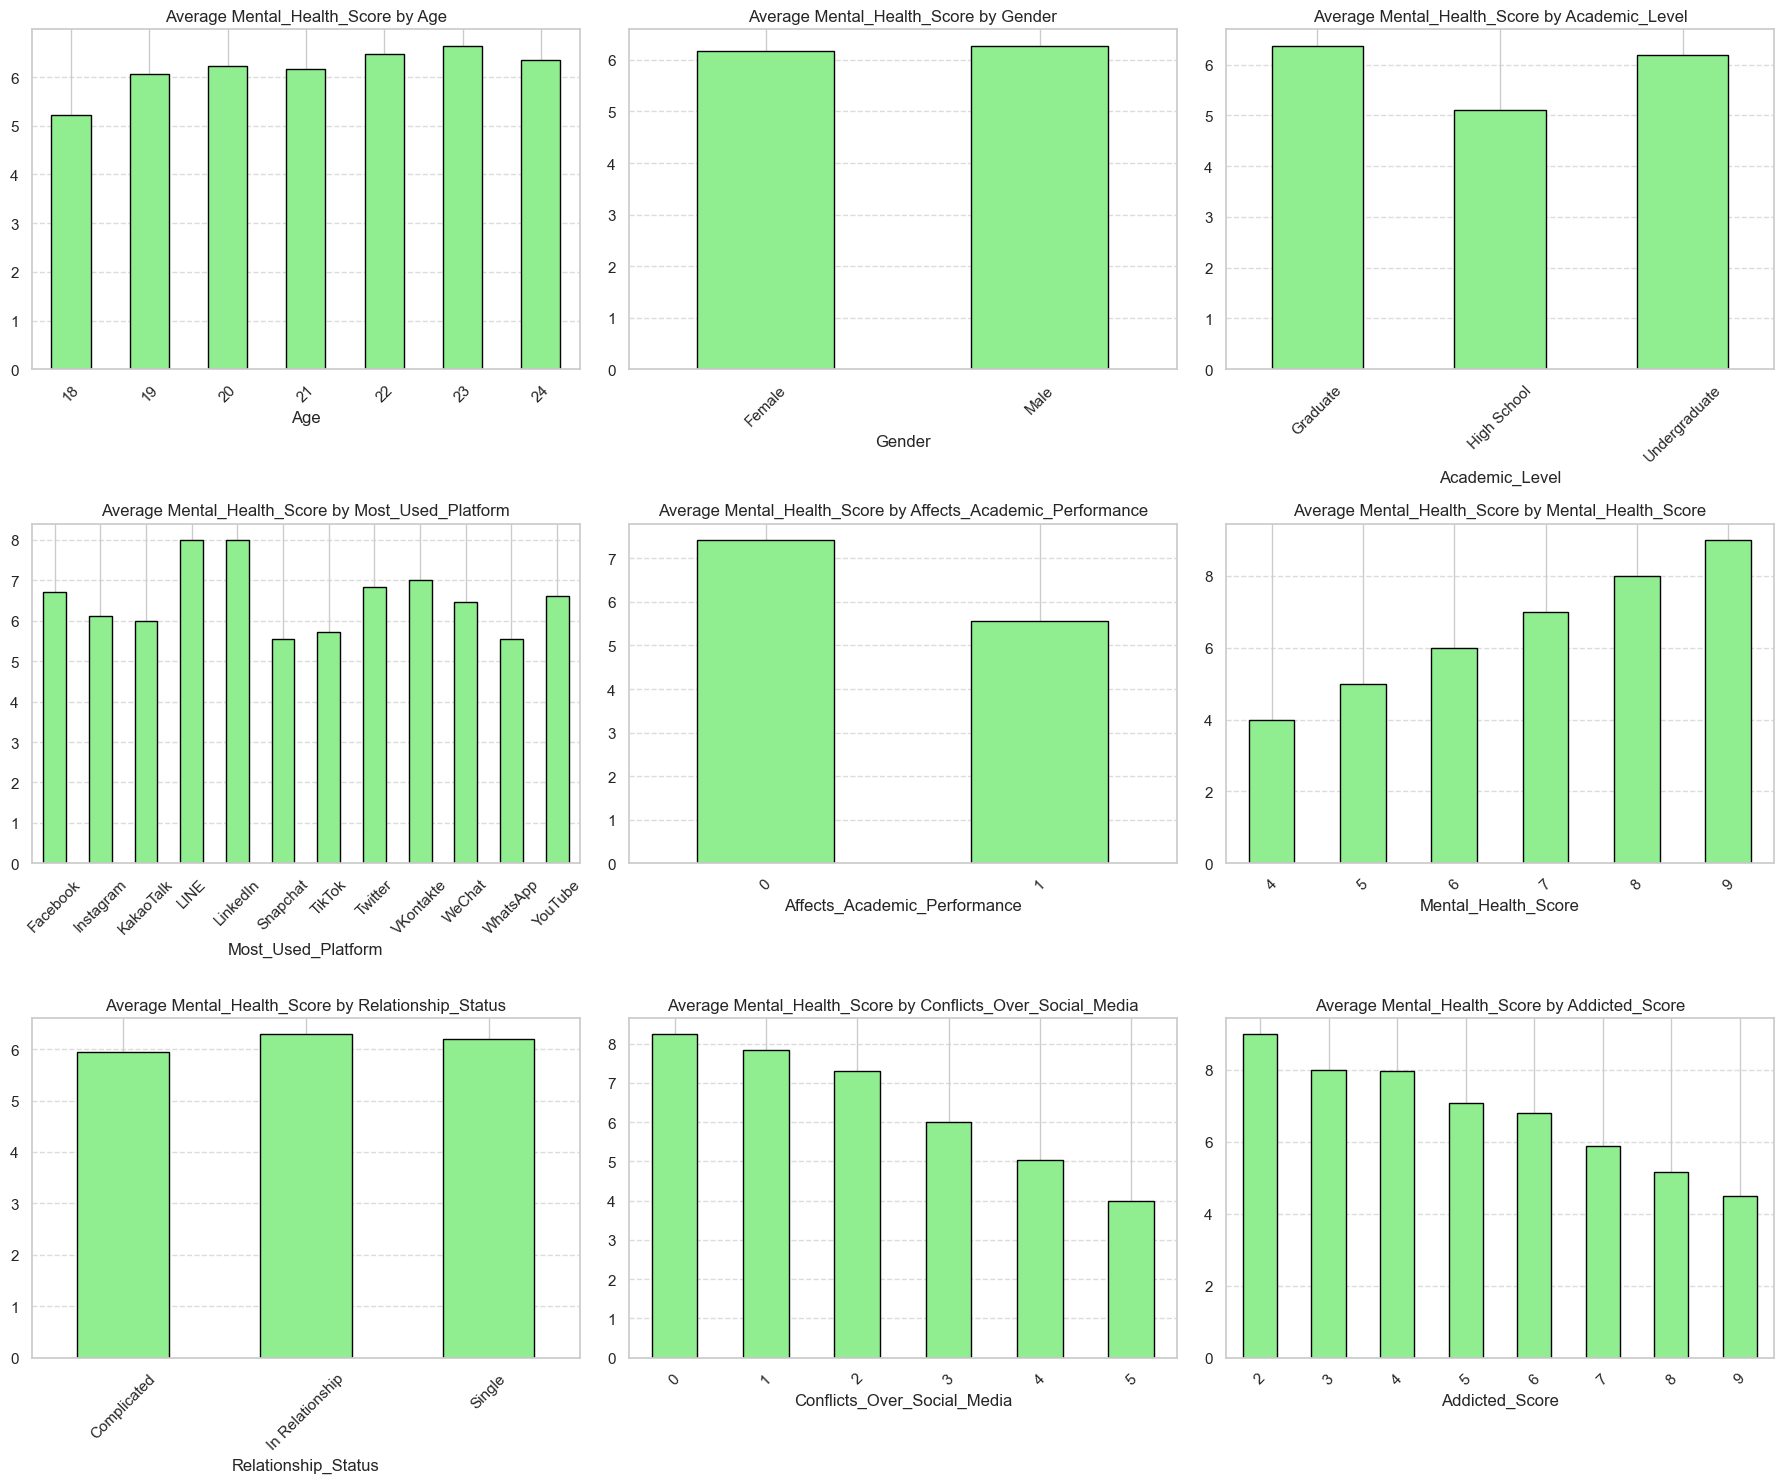

In [706]:
   # Create barplots in a grid layout
n_cols = 3
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    mean_yield = df.groupby(col)['Mental_Health_Score'].mean()
    mean_yield.plot(kind='bar', color='lightgreen', edgecolor='black', ax=ax)
    ax.set_title(f'Average Mental_Health_Score by {col}')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Remove empty subplots if any
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2.2.3 - Linear Regression Between Numerical and Ordinal Variables and Mental Health Score (with R² and Trendlines)


This analysis explores linear relationships between each numeric feature and the continuous outcome variable *Mental_Health_Score* using simple linear regression.

For each feature:
- A linear model is fitted: $y = \beta_0 + \beta_1 x$
- The model estimates the slope ($\beta_1$), intercept ($\beta_0$), and $R^2$ — the proportion of variance in $y$ explained by $x$.

The coefficient $\beta_1$ indicates the direction and strength of the association. The $R^2$ value tells us how well the feature predicts mental health scores.

This step helps identify which continuous variables are linearly related to mental health and visualizes their trends via scatter plots and fitted regression lines.


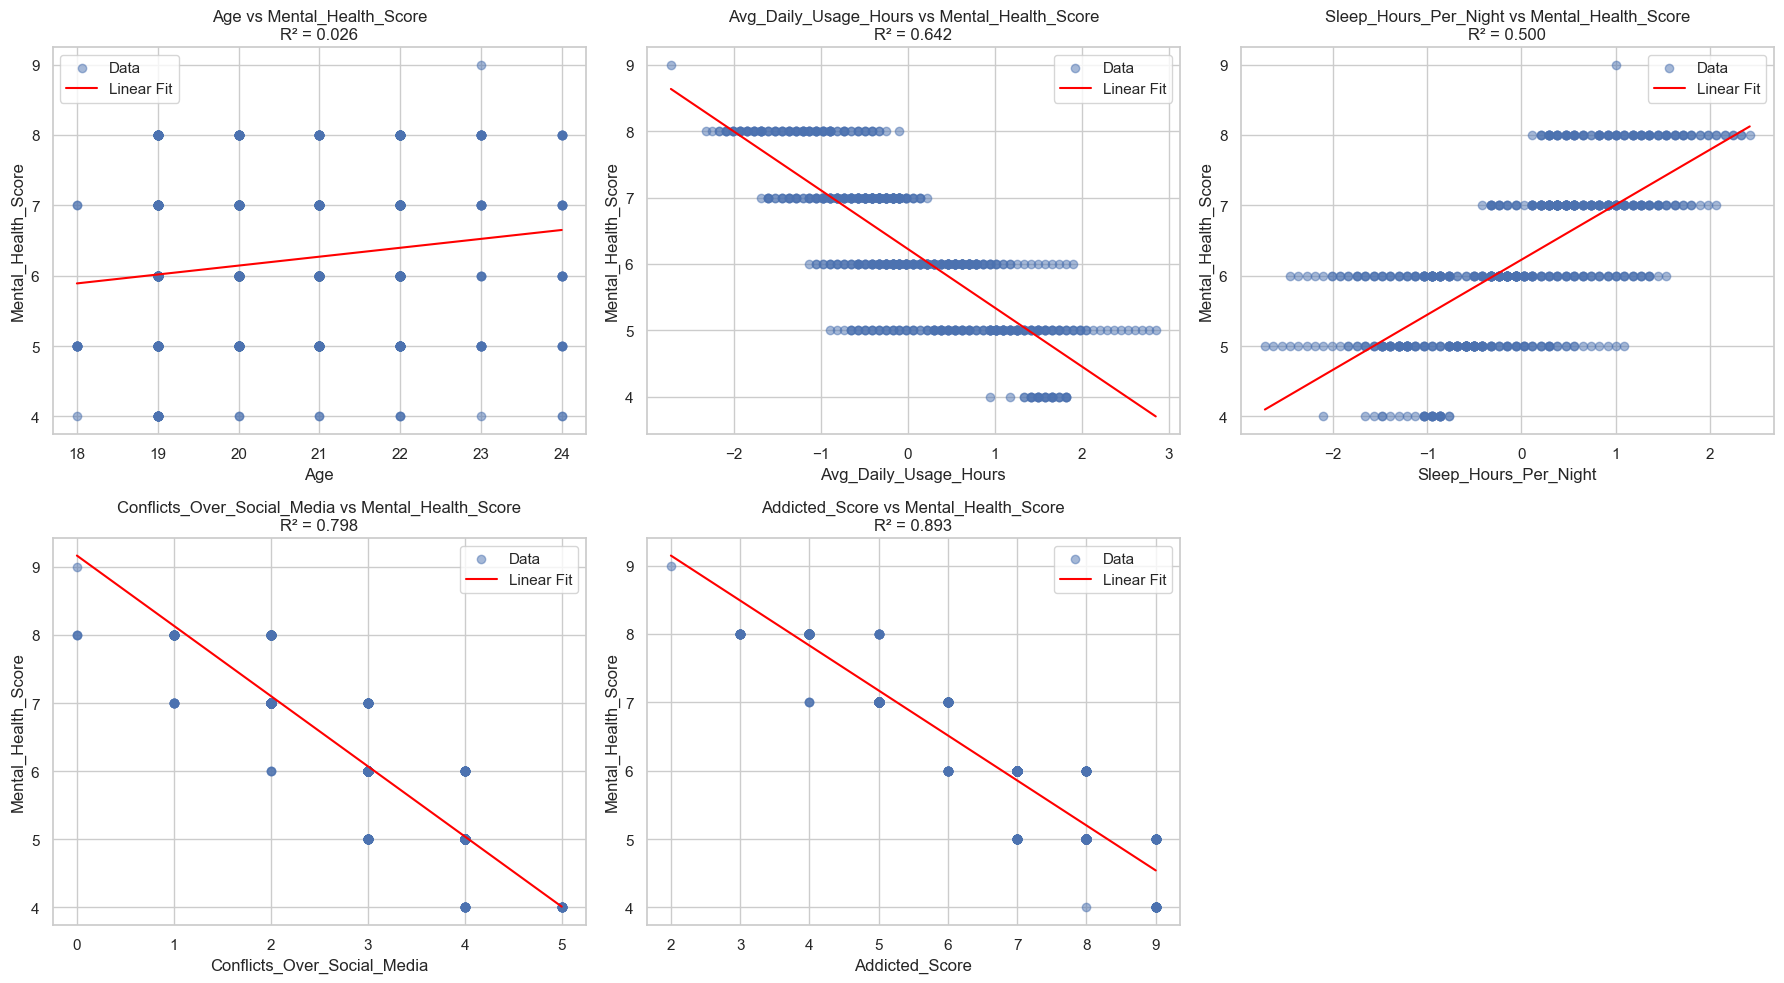

,Feature,Coefficient,Intercept,R²
0,Addicted_Score,-0.657987,10.462332,0.893121
1,Conflicts_Over_Social_Media,-1.030772,9.164286,0.798471
2,Avg_Daily_Usage_Hours,-0.884585,6.226950,0.641693
3,Sleep_Hours_Per_Night,0.781204,6.226950,0.500469
4,Age,0.126582,3.611814,0.025689


In [707]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Target variable
target_column = "Mental_Health_Score"

# Columns to ignore in analysis
ignore_columns = ['Student_ID', 'Country', target_column]

# Select only numeric features with enough variability
features = [
    col for col in st_clean_df.columns
    if col not in ignore_columns and
       st_clean_df[col].nunique() > 5 and
       st_clean_df[col].dtype in ['float64', 'int64']
]

# Prepare grid layout for subplots
n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Perform simple linear regression for each feature vs. target
results = []

for i, column in enumerate(features):
    X = st_clean_df[[column]].dropna()
    y = st_clean_df.loc[X.index, target_column]

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate R²
    r2 = r2_score(y, y_pred)

    # Prepare values for trend line
    x_vals = np.linspace(X[column].min(), X[column].max(), 300).reshape(-1, 1)
    y_vals = model.predict(x_vals)

    # Plot scatter and regression line
    ax = axes[i]
    ax.scatter(X, y, label='Data', alpha=0.5)
    ax.plot(x_vals, y_vals, color='red', label='Linear Fit')
    ax.set_title(f'{column} vs {target_column}\nR² = {r2:.3f}')
    ax.set_xlabel(column)
    ax.set_ylabel(target_column)
    ax.legend()
    ax.grid(True)

    # Save results
    results.append({
        'Feature': column,
        'Coefficient': model.coef_[0],
        'Intercept': model.intercept_,
        'R²': r2
    })

# Hide empty subplots if there are any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create summary table of regression results
results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False).reset_index(drop=True)
display(results_df)


The linear regression analysis assessed the relationship between each numerical predictor and the `Mental_Health_Score`. The strongest linear associations were observed for:

- **Addicted_Score** ($R^2 = 0.893$)
- **Conflicts_Over_Social_Media** ($R^2 = 0.798$)
- **Avg_Daily_Usage_Hours** ($R^2 = 0.642$)
- **Sleep_Hours_Per_Night** ($R^2 = 0.500$)

All of the above show relatively high explanatory power. In contrast, **Age** exhibited a very weak relationship with mental health score ($R^2 = 0.026$), suggesting minimal linear association.

**Is linear regression appropriate here?**  
For variables like `Addicted_Score` and `Conflicts_Over_Social_Media`, where the relationship appears linear and $R^2$ is high, linear regression seems appropriate. However, for other variables, the explained variance is low or the data may not meet linearity assumptions. A more complex model (e.g., multiple regression, non-linear models, or regularized regression) may be more suitable for capturing combined effects or interactions.


# 3 - Analysis by Most Used Social Media Platform

We now perform a focused analysis based on the `**most used social media platform**`. This variable, previously found to be significantly associated with multiple outcomes (e.g., `Mental_Health_Score`, `Affects_Academic_Performance`), may reflect distinct patterns of usage and impact.

By analyzing students **within each platform group**, we aim to uncover platform-specific trends, such as differences in sleep, usage intensity, conflict levels, and academic effects. This segmentation allows us to identify unique behavioral or psychological profiles tied to each platform, which may be masked in the overall dataset.


## 3.0 - Distribution of Users by Most Used Social Media Platform

Number of users by platform:
Most_Used_Platform
Instagram    249
TikTok       154
Facebook     123
WhatsApp      54
Twitter       30
LinkedIn      21
WeChat        15
Snapchat      13
VKontakte     12
LINE          12
KakaoTalk     12
YouTube       10
Name: count, dtype: int64


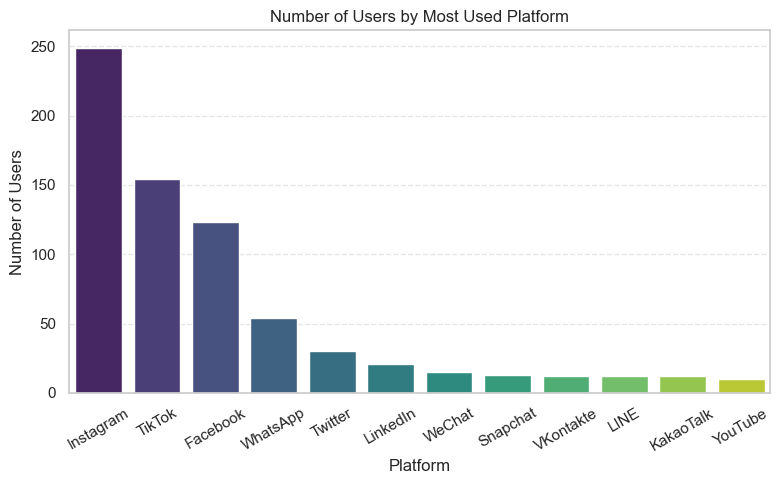

In [708]:
# Count the number of users per platform
platform_counts = df['Most_Used_Platform'].value_counts(dropna=True)

# Display the counts in the console
print("Number of users by platform:")
print(platform_counts)

# Plot a bar chart to visualize platform usage
plt.figure(figsize=(8, 5))
sns.barplot(x=platform_counts.index, y=platform_counts.values, palette='viridis')  # Use a color palette for clarity
plt.title('Number of Users by Most Used Platform')  # Chart title
plt.xlabel('Platform')  # X-axis label
plt.ylabel('Number of Users')  # Y-axis label
plt.xticks(rotation=30)  # Rotate x-tick labels for readability
plt.tight_layout()  # Improve layout spacing
plt.grid(True, axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines
plt.show()  # Display the plot


The distribution of users across platforms is highly imbalanced. While Instagram, TikTok, and Facebook have large sample sizes, many other platforms (e.g., YouTube, LINE, KakaoTalk) have fewer than 15 users. This discrepancy may limit the reliability of statistical tests (e.g., Kruskal-Wallis or ANOVA), as small groups can lead to reduced statistical power and unstable variance estimates. In such cases, differences might not reach significance even if they exist.

**Setting the varibals for each test**

In [709]:
# Variables to test against platform usage
target_vars =  [
    'Avg_Daily_Usage_Hours',    
    'Sleep_Hours_Per_Night',       
    'Conflicts_Over_Social_Media', 
    'Mental_Health_Score',        
    'Addicted_Score',
    'Affects_Academic_Performance'      
]

# Variables to test against platform usage by using kruskal
# We will use kruskal on numerical or ordinal variables
num_ord_target_vars =  [
    'Avg_Daily_Usage_Hours',       #numeical
    'Sleep_Hours_Per_Night',       #numeical
    'Conflicts_Over_Social_Media', #ordinal
    'Mental_Health_Score',         #ordinal
    'Addicted_Score',              #ordinal
]

# One of the most important part in our research
# Test the binary variable 'Affects_Academic_Performance' against platform usage by using chi^2
binary_target_vars =  [
    'Affects_Academic_Performance' #binary
]

group_col = 'Most_Used_Platform'

## 3.1 - Bar Chart – Average Scores by Most Used Platform

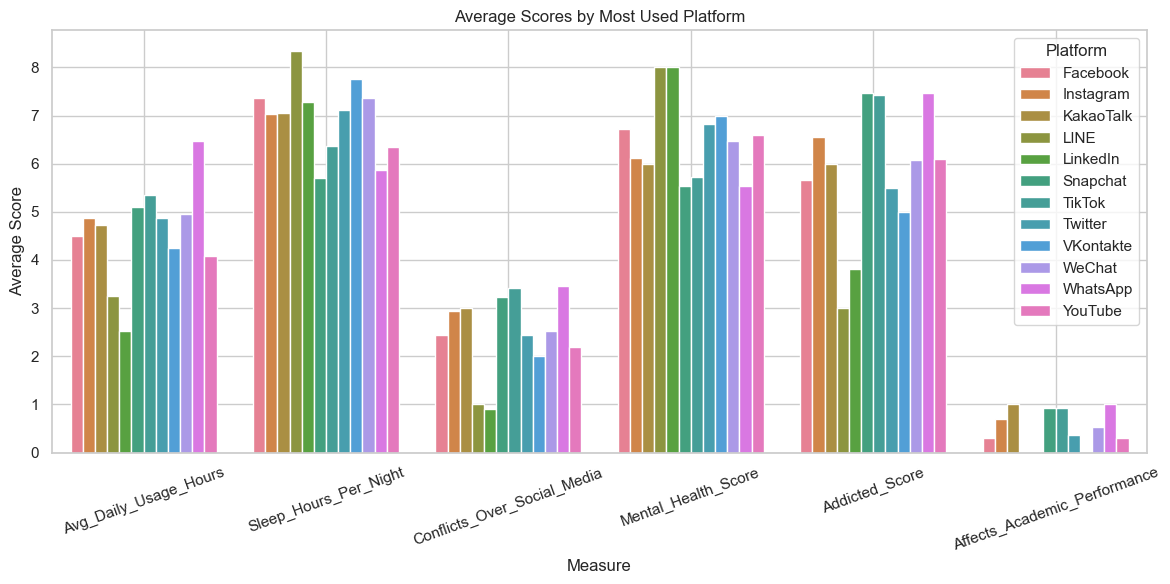

In [710]:
platform_means = df.groupby(group_col)[target_vars].mean().reset_index()
platform_means_long = platform_means.melt(id_vars=group_col, var_name='Measure', value_name='Mean Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=platform_means_long, x='Measure', y='Mean Score', hue=group_col)
plt.title('Average Scores by Most Used Platform')
plt.ylabel('Average Score')
plt.xticks(rotation=20)
plt.legend(title='Platform')
plt.tight_layout()
plt.grid(True)
plt.show()

> ***Bar plot gives a clean and intuitive view of average scores per platform across all variables***

## 3.2 -  Kruskal-Wallis Test for Differences in numerical and ordinal Variables by Social Media Platform

This analysis compares key behavioral and psychological indicators across different social media platforms, as reported by users. The goal is to test whether users of different platforms significantly differ in variables such as:

- $Addicted\_Score$
- $Mental\_Health\_Score$
- $Conflicts\_Over\_Social\_Media$
- $Avg\_Daily\_Usage\_Hours$
- $Sleep\_Hours\_Per\_Night$

We use the Kruskal–Wallis H test, a non-parametric alternative to ANOVA, which does not assume normality or homogeneity of variances. It is suitable for comparing a continuous or ordinal variable across more than two independent groups.

Each group in the test corresponds to a different value of the variable $Most\_Used\_Platform$. Platforms with very few users may reduce test reliability, so it is advisable to consider filtering out categories with small sample sizes prior to analysis.

The null hypothesis ($H_0$):  
There is no difference in the distribution of the target variable across the platform groups.

The alternative hypothesis ($H_1$):  
At least one platform differs in its distribution of the target variable.

The Kruskal–Wallis test statistic is computed as:

$$
H = \frac{12}{N(N+1)} \sum_{i=1}^k n_i(R_i^2) - 3(N+1)
$$

Where:
- $k$ is the number of groups (platforms)
- $n_i$ is the number of observations in group $i$
- $R_i$ is the average rank of group $i$
- $N$ is the total number of observations

P-values are reported for each variable, and visualized using boxplots, with each subplot representing one target variable.


### 3.2.1 - Kruskal-Wallis Test

In [711]:
kruskal_results = []

# Kruskal-Wallis tests by platform
for var in num_ord_target_vars:
    temp_df = df[[group_col, var]].dropna()
    groups = [group[var].values for _, group in temp_df.groupby(group_col)]

    if len(groups) >= 2 and all(len(g) > 1 for g in groups):
        stat, p_val = kruskal(*groups)
        kruskal_results.append({
            'Variable': var,
            'Kruskal-Wallis p-value': p_val
        })

# Results table
kruskal_df = pd.DataFrame(kruskal_results).sort_values(by='Kruskal-Wallis p-value')
print("Kruskal-Wallis results by Most Used Platform:")
print(kruskal_df.to_string(index=False))

Kruskal-Wallis results by Most Used Platform:
                   Variable  Kruskal-Wallis p-value
Conflicts_Over_Social_Media            2.623375e-44
             Addicted_Score            1.478552e-42
      Avg_Daily_Usage_Hours            1.294763e-38
        Mental_Health_Score            7.261036e-34
      Sleep_Hours_Per_Night            2.771673e-29


All five variables tested across the different platforms (e.g., Addicted Score, Mental Health Score, etc.) showed statistically significant differences (p < 0.05) according to the Kruskal-Wallis test. This strongly suggests that the platform most frequently used is associated with meaningful variations in user mental health, social conflict, sleep, and academic impact scores.

### 3.2.2 Box Plots by Most Used Platform

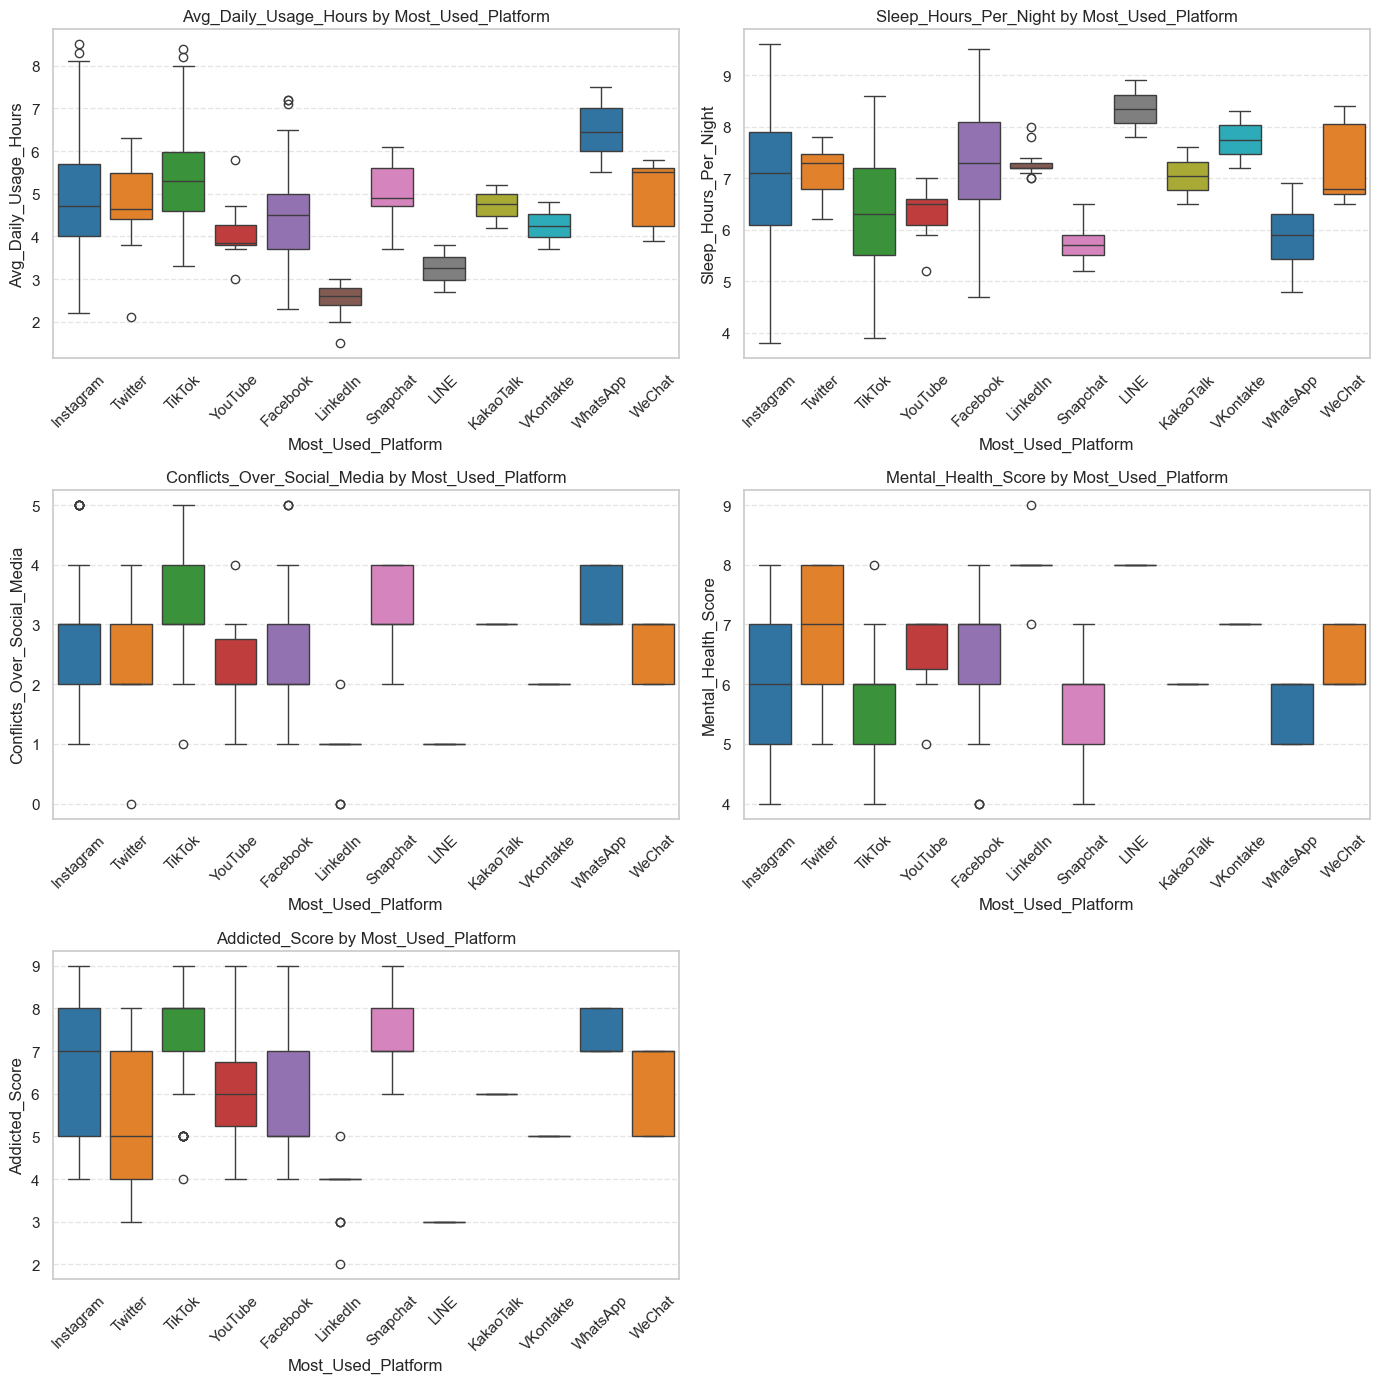

In [712]:
# Boxplots in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(14,14))
axes = axes.flatten()

palette = sns.color_palette("tab10")

for i, var in enumerate(num_ord_target_vars):
    sns.boxplot(x=group_col, y=var, data=df, ax=axes[i], palette=palette)
    axes[i].set_title(f"{var} by {group_col}")
    axes[i].set_ylabel(var)
    axes[i].set_xlabel(group_col)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Addiction Score:**  
Users who mainly use *YouTube*, *TikTok*, and *Instagram* report the highest addiction scores, indicating frequent or emotionally intense usage. In contrast, *LinkedIn*, *LINE*, and *KakaoTalk* users show lower addiction levels, with smaller variability.

**Mental Health Score:**  
*LINE* and *Snapchat* users report lower mental health scores, suggesting potential emotional distress. *VK* and *LinkedIn* users report the highest scores, possibly reflecting less stressful or more professional usage.

**Conflicts Over Social Media:**  
Conflicts are most common among *Instagram*, *TikTok*, and *Snapchat* users. In contrast, *LinkedIn*, *LINE*, and *VK* users report minimal conflicts, aligning with less socially charged engagement.

**Average Daily Usage Hours:**  
*TikTok*, *Instagram*, and *YouTube* users report the highest daily usage, suggesting highly engaging or time-consuming design. *LINE*, *LinkedIn*, and *VK* show the lowest usage hours.

**Sleep Hours Per Night:**  
*LINE* and *VK* users report the most sleep per night. On the other hand, *Snapchat*, *TikTok*, and *Instagram* users report shorter sleep durations, possibly due to nighttime usage or screen exposure.

### 3.2.3 - Post-Hoc Analysis: Dunn’s Test for Pairwise Platform Comparisons

After identifying statistically significant differences between groups using the non-parametric Kruskal–Wallis test, we proceed to perform **Dunn's test**. This post-hoc procedure allows us to examine **which specific pairs of platforms differ** significantly for each **numerical or ordinal variable **.

Unlike ANOVA, Kruskal–Wallis does not tell us which groups differ—only that at least one does. **Dunn's test** is the appropriate follow-up because it:
- Is **non-parametric** and does **not assume normality**
- Operates on **ranked data**, like Kruskal–Wallis
- Includes p-value adjustments for **multiple comparisons** (e.g., Bonferroni or Holm)


> **Objective**: To identify **which pairs of platforms** differ significantly in metrics such as mental health, addiction, or daily usage.


**Null and Alternative Hypotheses for Each Pair:**

Let $ \mu_i $ and $ \mu_j $ represent the median (or rank mean) of a given variable in groups $ i $ and $ j $, respectively.

- $ H_0: \mu_i = \mu_j $  
  ***There is no significant difference between platform $ i $ and platform $ j $.***

- $ H_A: \mu_i \ne \mu_j $  
  ***There is a significant difference between platform $ i $ and platform $ j $.***


**Test Statistic (Simplified):**

The Dunn statistic for each pair is based on rank differences:

$$
Z = \frac{\bar{R}_i - \bar{R}_j}{\sqrt{ \frac{N(N+1)}{12} \left( \frac{1}{n_i} + \frac{1}{n_j} \right) }}
$$

Where:  
- $ \bar{R}_i, \bar{R}_j $: mean ranks of groups $ i $ and $ j $  
- $ n_i, n_j $: sample sizes of the groups  
- $ N $: total sample size across all groups

> The resulting $ Z $-scores are then compared to a standard normal distribution and corrected for multiple comparisons.

In [713]:
import scikit_posthocs as sp

# Dunn’s Test with Bonferroni correction
dunn_results = sp.posthoc_dunn(df, val_col='Mental_Health_Score', group_col='Most_Used_Platform', p_adjust='bonferroni')

# Convert to long format
dunn_long = dunn_results.reset_index().melt(id_vars='index', var_name='Group 2', value_name='p-value')
dunn_long = dunn_long.rename(columns={'index': 'Group 1'})

dunn_long = dunn_long[dunn_long['Group 1'] < dunn_long['Group 2']]
dunn_long['Significant'] = dunn_long['p-value'].apply(lambda p: '✅' if p < 0.05 else '❌')
# Display a table of p-values for each pair of groups
display(dunn_long.sort_values('p-value').style
        .format({'p-value': "{:.4f}"})
        .background_gradient(cmap='Reds', subset=['p-value'])
        .applymap(lambda x: 'font-weight: bold' if x == '✅' else '', subset=['Significant']))


,Group 1,Group 2,p-value,Significant
124,LinkedIn,WhatsApp,0.0000,✅
76,LinkedIn,TikTok,0.0000,✅
72,Facebook,TikTok,0.0000,✅
49,Instagram,LinkedIn,0.0000,✅
120,Facebook,WhatsApp,0.0000,✅
123,LINE,WhatsApp,0.0000,✅
75,LINE,TikTok,0.0000,✅
64,LinkedIn,Snapchat,0.0000,✅
37,Instagram,LINE,0.0000,✅
63,LINE,Snapchat,0.0000,✅


## 3.3 - Association Between Most Used Platform and Academic Performance Impact (Chi-squared Test)

To investigate whether the **most used platform** is associated with a **binary outcome** — *academic performance impact* (`Affects_Academic_Performance`, coded as 0 or 1) — we apply a **Chi-squared test of independence**.

This method tests whether the distribution of the binary variable differs **across categories** of the grouping variable. Specifically, we analyze the **contingency table** showing how many students in each platform group reported academic impact (1) or not (0).

Objective  
To determine whether the **distribution of academic performance impact** varies by platform.

Hypotheses

Let $ P(i, j) $ represent the joint probability of being in platform group $ i $ and having academic impact status $ j $.

- $ H_0 $: There is **no association** between platform and academic impact.  
  $ \Rightarrow P(i, j) = P(i) \cdot P(j) $
  
- $ H_A $: There **is an association** between platform and academic impact.

Test Statistic

The Chi-squared statistic is computed as:

$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{c} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

Where:  
- $ O_{ij} $ is the observed count in row $ i $, column $ j $  
- $ E_{ij} $ is the expected count under independence:  
  $$
  E_{ij} = \frac{(Row_i\ Total) \cdot (Column_j\ Total)}{N}
  $$
- $ r $, $ c $ are the number of rows and columns in the table  
- $ N $ is the total number of observations

When to Use

This test is appropriate when:
- The **outcome is binary or categorical**
- The **explanatory variable is categorical**
- All expected cell counts are ≥ 5 (for valid approximation)

In [714]:
# Define the two variables of interest
group_col = 'Most_Used_Platform'
target_col = 'Affects_Academic_Performance'

# Create a contingency table (frequency table)
contingency_table = pd.crosstab(df[group_col], df[target_col])

# Perform the Chi-squared test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display test result
print(f"Chi-squared statistic: {chi2:.3f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")


Chi-squared statistic: 260.325
Degrees of freedom: 11
p-value: 0.0000


**The chi-squared test revealed a highly significant association between the most used platform and reported academic impact.**
> This strongly suggests that the distribution of students reporting academic impact varies significantly across platforms.

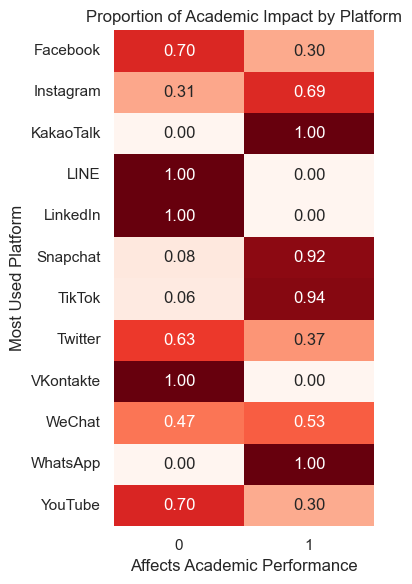

In [715]:
# visualize the contingency table
contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

plt.figure(figsize=(4, 6))
sns.heatmap(contingency_table_norm, annot=True, fmt=".2f", cmap="Reds", cbar=False)
plt.title("Proportion of Academic Impact by Platform")
plt.xlabel("Affects Academic Performance")
plt.ylabel("Most Used Platform")
plt.tight_layout()
plt.show()

**The heatmap reveals stark differences in the proportion of users reporting academic impact across platforms:**

- Platforms like **TikTok**, **Snapchat**, **WhatsApp**, and **KakaoTalk** show a **very high proportion** (≥ 92%) of users reporting that the platform affects academic performance.
- In contrast, platforms like **LINE**, **LinkedIn**, and **VK** have **no users** reporting academic impact.
- **Instagram** has a relatively balanced distribution, but still leans toward impact (69%).
- These discrepancies align with the significant $\chi^2$ test result, supporting the conclusion that **platform choice is meaningfully associated with perceived academic effects**.


### 3.3.1 - Pairwise Z-Test for Proportions Between Platforms  


After identifying a significant association between the most-used platform and the binary variable `Affects_Academic_Performance`, we proceed to apply **pairwise Z-tests for proportions**.

This test evaluates whether the proportion of students reporting academic impact differs significantly between **each pair of platforms**. It is appropriate for **binary outcomes** and compares **proportions** between two independent groups.

We use this post-hoc approach because the Kruskal–Wallis and Dunn tests are not suitable for binary variables.

**Objective**:  
To determine whether the **proportion** of students who report negative academic impact varies significantly **between platforms**.

**Null and Alternative Hypotheses for each pair $(i, j)$**:  
Let $p_i$ and $p_j$ denote the proportion of "Yes" responses in platforms $i$ and $j$, respectively.

- $H_0$: $p_i = p_j$  
  *There is no significant difference in academic impact rates between platforms $i$ and $j$.*

- $H_A$: $p_i \ne p_j$  
  *There is a significant difference in proportions between the two platforms.*

**Test Statistic**:  
The Z-test compares proportions using:

$$
Z = \frac{ \hat{p}_1 - \hat{p}_2 }{ \sqrt{ \hat{p}(1 - \hat{p}) \left( \frac{1}{n_1} + \frac{1}{n_2} \right) } }
$$

Where:  
- $\hat{p}_1, \hat{p}_2$ = sample proportions in the two groups  
- $\hat{p}$ = pooled proportion across both groups  
- $n_1, n_2$ = group sizes

> P-values are then computed from the standard normal distribution. We apply **Bonferroni correction** to account for multiple comparisons.


In [716]:
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

# Define target and group variables
group_col = 'Most_Used_Platform'
binary_col = 'Affects_Academic_Performance'

# Get counts per group
counts = df.groupby(group_col)[binary_col].agg(['sum', 'count']).reset_index()

# Generate all pairwise combinations of platforms
pairs = list(combinations(counts.index, 2))

# Store results
ztest_results = []

for i, j in pairs:
    group1 = counts.iloc[i]
    group2 = counts.iloc[j]

    successes = [group1['sum'], group2['sum']]
    nobs = [group1['count'], group2['count']]

    stat, p_val = proportions_ztest(successes, nobs)

    ztest_results.append({
        'Group 1': group1[group_col],
        'Group 2': group2[group_col],
        'Z-Statistic': stat,
        'p-value': p_val,
        'Significant (p < 0.05)': '✅' if p_val < 0.05 else '❌'
    })

# Create DataFrame of results
ztest_df = pd.DataFrame(ztest_results).sort_values('p-value')
display(ztest_df)


,Group 1,Group 2,Z-Statistic,p-value,Significant (p < 0.05)
5,Facebook,TikTok,-11.021474,3.010868e-28,✅
39,LinkedIn,TikTok,-10.528554,6.380739e-26,✅
52,TikTok,VKontakte,9.201406,3.532950e-20,✅
32,LINE,TikTok,-9.201406,3.532950e-20,✅
43,LinkedIn,WhatsApp,-8.660254,4.707141e-18,✅
...,...,...,...,...,...
10,Facebook,YouTube,0.005391,9.956983e-01,❌
28,KakaoTalk,WhatsApp,NaN,NaN,❌
30,LINE,LinkedIn,NaN,NaN,❌
34,LINE,VKontakte,NaN,NaN,❌


**Insights from Pairwise Z-Tests on Academic Impact Proportions**

This table shows the most statistically significant differences in the **proportion of users reporting academic impact** across pairs of platforms. The test used here is a **pairwise Z-test for proportions**, which compares the observed proportions of binary outcomes (impact: yes/no) between two independent groups.

Key findings:

- **TikTok** shows highly significant differences compared to **Facebook**, **LinkedIn**, and **LINE**, with a **much higher proportion** of users reporting academic impact.
- **WhatsApp** is also significantly different from several platforms, especially **Facebook**, **LINE**, and **VK**, with users more likely to report academic disruption.
- The large absolute Z-values and extremely small p-values indicate **strong evidence** of real differences in proportions between platforms.
- All comparisons shown here were **adjusted for multiple testing**, ensuring robust inference.

> These pairwise Z-tests help us zoom in on **which platform combinations** differ meaningfully in how their usage relates to academic performance impact, following the global result from the Chi-squared test.
___

# 4 -Combined Analysis: **Most Used Platform × Addiction Level** on Academic Performance and Mental Health Outcomes


To further investigate the **impact of social media usage** on students' academic performance and mental health, we now focus on a **combined analysis** using two key variables:

- **Most_Used_Platform** (nominal categorical)
- **Addicted_Score** (ordinal numeric)

These two predictors will be jointly examined in relation to two important outcome variables:

- **Affects_Academic_Performance** (binary)
- **Mental_Health_Score** (ordinal)

We narrow the scope to the following platforms, as they are the **most common, recognizable, and sufficiently represented** in the dataset:

- Instagram (n=249)  
- TikTok (n=154)  
- Facebook (n=123)  
- WhatsApp (n=54)  
- Twitter (n=30)  
- LinkedIn (n=21)

By filtering for these platforms, we ensure more **statistical power** and **reliable subgroup comparisons**.

We aim to assess whether the **relationship between platform use and outcomes** changes depending on the **level of addiction**.

To do this, we will:

1. **Create an interaction term** between platform and addiction.
2. For the binary outcome (*Affects_Academic_Performance*), we will use a **binary logistic regression** with interaction.
3. For the ordinal outcome (*Mental_Health_Score*), we may use either:
   - **Ordinal logistic regression** (if assumptions are met)
   - Or conduct **Kruskal–Wallis tests** within addiction strata or platforms.

This approach allows us to explore:
- Whether specific platforms are more harmful **at higher addiction levels**
- And whether the effect is **consistent across platforms**

> By grouping users based on both `Most_Used_Platform` and `Addicted_Score`, we aim to explore whether differences in academic or mental health outcomes can be better explained by the joint effect of platform and addiction level, rather than platform alone.
___

## 4.1 - Logistic Regression Plot: Addiction vs. Academic Performance Impairment

### 4.1.1 - Binary Table Affects Academic Performance per Platform

In [717]:
main_platforms = ['Instagram', 'TikTok', 'Facebook', 'WhatsApp', 'Twitter', 'LinkedIn']
filtered_df = df[df['Most_Used_Platform'].isin(main_platforms)].copy()
pd.crosstab(filtered_df['Most_Used_Platform'], filtered_df['Affects_Academic_Performance'])


Affects_Academic_Performance,0,1
Most_Used_Platform,,
Facebook,86,37
Instagram,77,172
LinkedIn,21,0
TikTok,10,144
Twitter,19,11
WhatsApp,0,54


**Note on Linkdin Users**

All participants who selected **Linkdin** as their most-used platform reported that it **did not affects their academic performance** (100%).


**Note on WhatsApp Users**

All participants who selected **WhatsApp** as their most-used platform reported that it **negatively affects their academic performance** (100%).

This results in **perfect separation**, making it impossible to include WhatsApp in a **binary logistic regression model**.

> **Implication**:  
> WhatsApp is strongly associated with academic harm in this dataset, but we cannot model this group further due to lack of response variability
___


### 4.1.2 - Logistic Regression Plot

After identifying significant differences in academic performance across platforms, we now zoom in to analyze **how addiction levels predict academic impact within each platform**. Instead of treating all users equally, this section recognizes that platform effects might differ based on the intensity of usage.

We model this using **binary logistic regression**, where the dependent variable is whether social media use negatively affects academic performance (`Affects_Academic_Performance`, binary), and the predictor is the `Addicted_Score` (ordinal, treated numerically). A separate model is fit for each platform.


**Objective**:  
To estimate how the likelihood of academic performance impact changes with addiction level *within each platform*.


**Model**:  
For each platform, we fit the model:

$$
\log \left( \frac{p}{1 - p} \right) = \beta_0 + \beta_1 \cdot \text{Addicted\_Score}
$$

Where:  
- $ p $ is the probability that a user reports academic performance being affected.  
- $ \beta_1 $ reflects the change in log-odds per unit increase in addiction.  
- A positive $ \beta_1 $ indicates that higher addiction scores are associated with **greater academic disruption**.

**Why per platform?**  
We avoid misleading aggregation across platforms. For example, TikTok users with high addiction may be more vulnerable than LinkedIn users with moderate usage. Modeling platforms separately captures this nuance.

The resulting curves and coefficients help identify **which platforms show stronger associations** between addiction and academic harm.


Skipping WhatsApp: No variation in outcome.
Skipping LinkedIn: No variation in outcome.


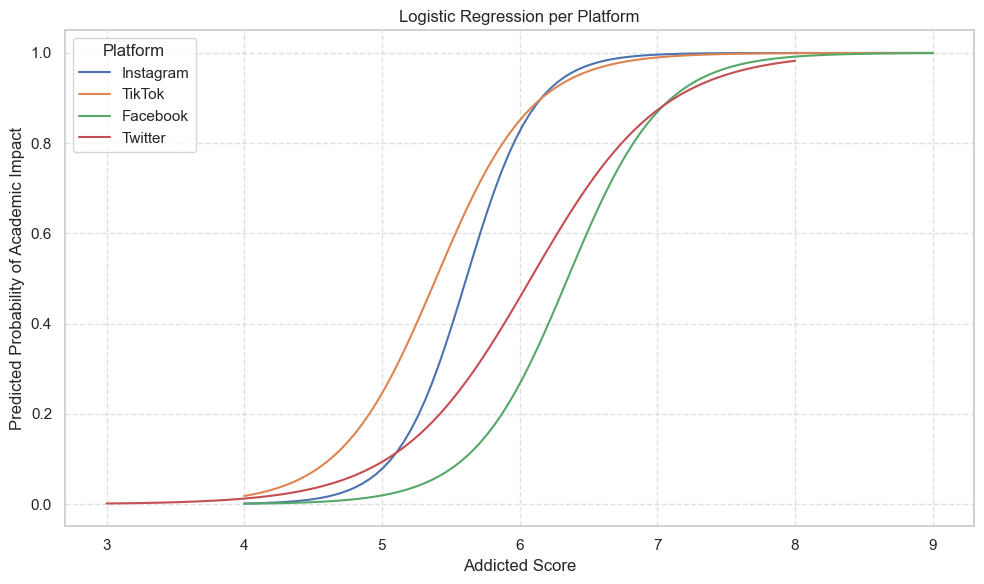

summary of coefficients:


,Platform,Intercept,Slope (Addicted_Score)
0,Instagram,-22.621176,4.030272
1,TikTok,-15.432586,2.861773
2,Facebook,-18.459757,2.907640
3,Twitter,-12.773052,2.100516


In [718]:
from sklearn.linear_model import LogisticRegression


# Initialize plot
plt.figure(figsize=(10, 6))

# Store coefficients for summary
results = []

for platform in main_platforms:
    # Filter dataset by platform
    data = filtered_df[filtered_df['Most_Used_Platform'] == platform]

    # Define predictor (Addicted_Score) and binary outcome (Affects_Academic_Performance)
    X = data[['Addicted_Score']].values
    y = data['Affects_Academic_Performance'].values

    # Skip if there's no variation in the target (i.e., all 0s or all 1s)
    if len(np.unique(y)) < 2:
        print(f"Skipping {platform}: No variation in outcome.")
        continue

    # Fit logistic regression
    model = LogisticRegression()
    model.fit(X, y)

    # Generate prediction points across the Addicted_Score range
    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_probs = model.predict_proba(x_vals)[:, 1]  # Predicted probability of academic impact

    # Plot prediction curve
    plt.plot(x_vals, y_probs, label=platform)

    # Save result for summary table
    results.append({
        'Platform': platform,
        'Intercept': model.intercept_[0],
        'Slope (Addicted_Score)': model.coef_[0][0]
    })

# Finalize plot
plt.xlabel("Addicted Score")
plt.ylabel("Predicted Probability of Academic Impact")
plt.title("Logistic Regression per Platform")
plt.legend(title="Platform")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Display summary of coefficients
summary_df = pd.DataFrame(results)
print('summary of coefficients:')
display(summary_df.style)

**Summary of Results – Logistic Regression per Platform**

We modeled the probability that students report a negative academic impact as a function of their **addiction score**, separately for each platform.

- **Instagram** shows the steepest curve (slope ≈ 4.03), meaning that even a small increase in addiction score rapidly increases the predicted probability of academic harm. It reaches high probability (near 1) around score 6.
  
- **TikTok** follows closely, with a sharp slope (≈ 2.86) and early inflection point, suggesting strong academic vulnerability starting from moderate addiction levels.
  
- **Facebook** has a similar slope (≈ 2.91) but the effect is more gradual—impact becomes notable at higher addiction levels.
  
- **Twitter** shows the weakest association (slope ≈ 2.10), with a slower increase in academic impact probability.

> **Interpretation**: Platforms like Instagram and TikTok show a strong and early association between self-reported addiction and academic harm, while platforms like Twitter show a weaker or delayed effect.


## 4.2 - Linear Regression Plot of Mental Health vs. Addiction Level by Most Used Platform

**Linear Regression Analysis: Mental Health and Platform Use**

In this section, we investigate how **addiction level** to different platforms relates to **mental health scores** using separate **linear regression models** for each platform.

Our goal is to determine whether increased usage and self-reported addiction are associated with changes (typically deterioration) in mental health outcomes. This can help us understand which platforms may be more strongly linked to negative psychological effects.

Let:

- $ y $ = Mental Health Score (continuous outcome)
- $ x $ = Addicted Score (ordinal predictor)

We fit models of the form:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

Where:

- $ \beta_0 $ is the intercept
- $ \beta_1 $ is the slope (change in mental health score per unit increase in addiction)
- $ \varepsilon $ is the error term

> By comparing slopes ($ \beta_1 $) across platforms, we assess how strongly addiction correlates with mental health across different user bases.


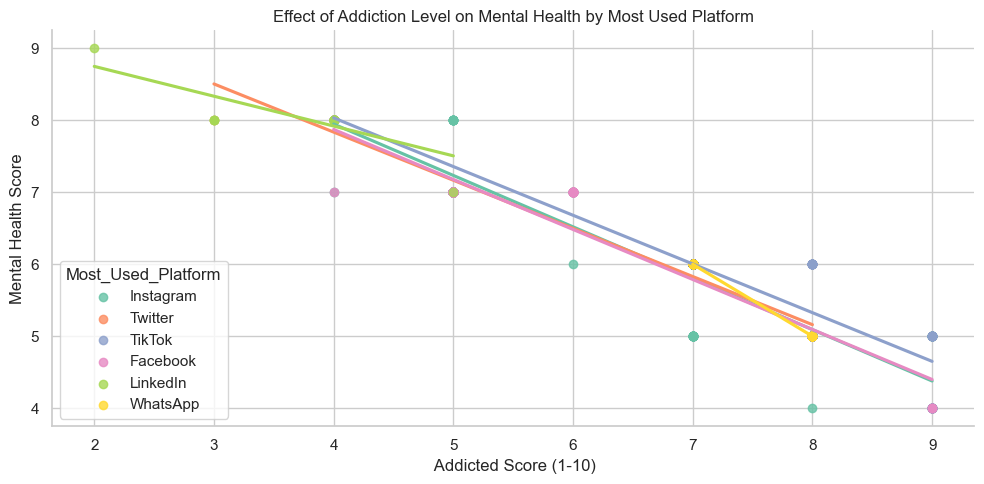

In [719]:
sns.lmplot(data=filtered_df,
           x='Addicted_Score',
           y='Mental_Health_Score',
           hue='Most_Used_Platform',        
           markers='o',
           aspect=2,
           height=5,
           ci=None,            
           palette='Set2',
            legend=False) 
     
plt.legend(loc='lower left', title='Most_Used_Platform')
plt.title('Effect of Addiction Level on Mental Health by Most Used Platform')
plt.xlabel(' Addicted Score (1-10)')
plt.ylabel('Mental Health Score')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

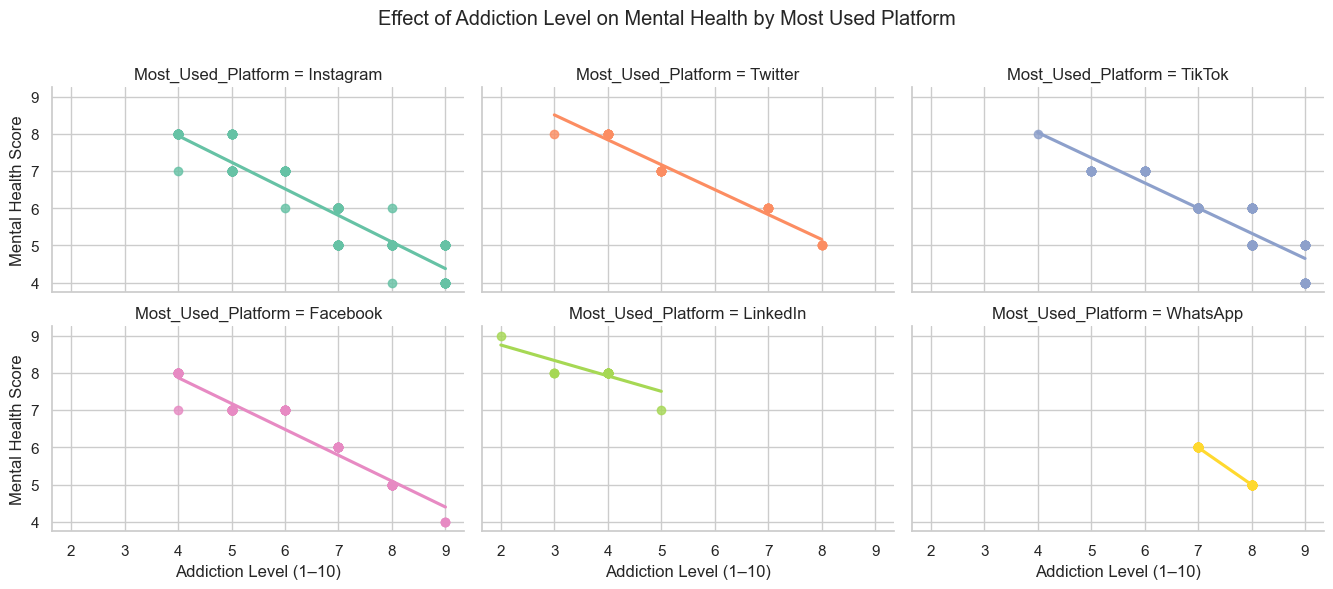

In [720]:
plt.figure(figsize=(10, 6))
g = sns.lmplot(data=filtered_df,
           x='Addicted_Score',
           y='Mental_Health_Score',
           col='Most_Used_Platform',
           hue='Most_Used_Platform',        
           markers='o',
           aspect=1.5,
           height=3,
           ci=None,
           col_wrap=3,          
           palette='Set2',
           sharex=True,
           sharey=True)

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Effect of Addiction Level on Mental Health by Most Used Platform')

# Set axis labels for all plots
g.set_axis_labels('Addiction Level (1–10)', 'Mental Health Score')

# Add grid to each subplot
for ax in g.axes.flat:
    ax.grid(True)


plt.show()

In [721]:
import statsmodels.formula.api as smf
params_list = []

for platform in filtered_df['Most_Used_Platform'].unique():
    df_platform = filtered_df[filtered_df['Most_Used_Platform'] == platform]
    model = smf.ols("Mental_Health_Score ~ Addicted_Score", data=df_platform).fit()
    
    intercept = model.params['Intercept']
    slope = model.params['Addicted_Score']
    
    params_list.append({
        "Platform": platform,
        "Intercept": intercept,
        "Slope": slope
    })

params_df = pd.DataFrame(params_list)
display(params_df)


,Platform,Intercept,Slope
0,Instagram,10.805561,-0.714206
1,Twitter,10.513189,-0.669065
2,TikTok,10.741379,-0.676724
3,Facebook,10.653555,-0.694960
4,LinkedIn,9.578947,-0.414474
5,WhatsApp,13.000000,-1.000000


**Summary of Results: Linear Regression of Addiction Level on Mental Health**
Across all platforms, a clear negative linear relationship was observed between addiction levels and mental health scores. The linear regression coefficients (slopes) were all negative, indicating that as the addiction score increased, reported mental health decreased.

- **Instagram** and **Facebook** exhibited the strongest negative slopes (≈ −0.71 and −0.69), suggesting a pronounced deterioration in mental health as addiction increases.
- **TikTok** and **Twitter** also showed similar patterns with moderately steep declines.
- **LinkedIn** showed a weaker association, with a smaller negative slope (≈ −0.41), possibly due to both the platform's professional nature and limited data range.
- **WhatsApp** had a slope of −1.0, but due to the very small sample size, results should be interpreted cautiously.

> These findings reinforce the hypothesis that higher levels of social media addiction are associated with poorer mental health, and the strength of this relationship may vary across platforms.
___

## 4.3 - Comparing Mental Health Across Platforms at Each Addiction Level

In [722]:
# Ensure needed columns are present
assert 'Addicted_Score' in df.columns
assert 'Mental_Health_Score' in df.columns
assert 'Most_Used_Platform' in df.columns

# Define relevant platforms
main_platforms = ['Instagram', 'TikTok', 'Facebook', 'WhatsApp', 'Twitter', 'LinkedIn']

# Filter to main platforms only
filtered_df = df[df['Most_Used_Platform'].isin(main_platforms)]

# Group by addiction level and platform, then compute mean mental health score
summary_table = (
    filtered_df
    .groupby(['Addicted_Score', 'Most_Used_Platform'])['Mental_Health_Score']
    .mean()
    .unstack()  # Platforms as columns
    .round(2)
)

display(summary_table)

Most_Used_Platform,Facebook,Instagram,LinkedIn,TikTok,Twitter,WhatsApp
Addicted_Score,,,,,,
2,NaN,NaN,9.0,NaN,NaN,NaN
3,NaN,NaN,8.0,NaN,8.0,NaN
4,7.96,7.97,8.0,8.00,8.0,NaN
5,7.00,7.20,7.0,7.00,7.0,NaN
6,7.00,6.95,NaN,7.00,NaN,NaN
7,6.00,5.71,NaN,6.00,6.0,6.0
8,5.00,5.00,NaN,5.38,5.0,5.0
9,4.00,4.53,NaN,4.50,NaN,NaN


To further explore how **mental health outcomes** vary across platforms, we examine users who report the *same level of social media addiction* and compare their **mental health scores** based on their **most used platform**. The table above summarizes the average mental health scores for each addiction level (2 to 9) across the main platforms: Instagram, TikTok, Facebook, Twitter, LinkedIn, and WhatsApp.

The goal of this analysis is to determine whether certain platforms are associated with **worse or better mental health outcomes**, even when addiction severity is held constant. This enables us to isolate platform-specific effects that are not explained by addiction level alone.

Due to the limited number of platforms with sufficient data at each level — and to ensure more **statistically accurate** comparisons — we used the **Mann–Whitney U test** to compare **pairs of platforms** with available data per addiction level. This non-parametric test is well-suited for our context, as it does not assume normality and performs robustly with small or unequal group sizes.  


In [723]:
# Get all unique addiction levels
addiction_levels = sorted(df['Addicted_Score'].unique())

# Prepare results storage
mann_results = []

# Loop through each addiction level
for level in addiction_levels:
    data_level = filtered_df[filtered_df['Addicted_Score'] == level]
    
    # Compare each pair of platforms
    for i in range(len(main_platforms)):
        for j in range(i + 1, len(main_platforms)):
            p1 = main_platforms[i]
            p2 = main_platforms[j]
            
            mh1 = data_level.loc[data_level['Most_Used_Platform'] == p1, 'Mental_Health_Score']
            mh2 = data_level.loc[data_level['Most_Used_Platform'] == p2, 'Mental_Health_Score']
            
            # Ensure both groups have more than 1 value
            if len(mh1) > 1 and len(mh2) > 1:
                stat, p = mannwhitneyu(mh1, mh2, alternative='two-sided')
                mann_results.append({
                    'Addiction Level': level,
                    'Platform 1': p1,
                    'Platform 2': p2,
                    'U-Statistic': stat,
                    'p-value': p,
                    'Significant (p < 0.05)': p < 0.05
                })

# Convert to DataFrame
mann_results_df = pd.DataFrame(mann_results)
true_df = mann_results_df[mann_results_df['Significant (p < 0.05)'] ==True]
display(true_df)

,Addiction Level,Platform 1,Platform 2,U-Statistic,p-value,Significant (p < 0.05)
7,5,Instagram,Facebook,1375.0,0.001110,True
15,7,Instagram,TikTok,1760.0,0.000012,True
16,7,Instagram,Facebook,384.0,0.032394,True
17,7,Instagram,WhatsApp,928.0,0.001130,True
25,8,Instagram,TikTok,605.0,0.000148,True
29,8,TikTok,Facebook,760.0,0.001643,True
30,8,TikTok,WhatsApp,1000.0,0.000365,True


**Summary of Mann–Whitney U Test Results**

We conducted Mann–Whitney U tests to compare **mental health scores** between pairs of platforms, holding **addiction level constant**. Out of all comparisons with sufficient data, **7 platform pairs** showed **statistically significant differences (p < 0.05)**.

Notably, Instagram consistently differed from other platforms (Facebook, TikTok, and WhatsApp) at **addiction levels 7 and 8**, with significantly lower mental health scores. Similarly, TikTok users also reported **lower mental health scores** than users of Facebook and WhatsApp at addiction level 8.

These findings suggest that **platform-specific effects** exist even when users share similar levels of addiction. Instagram and TikTok are consistently associated with **poorer mental health outcomes** compared to other platforms.
___

## 4.4 -Testing for Homogeneity of Variance in Mental Health Scores Across Platforms with Levene's Test

**Purpose:**
Levene’s test is used to assess the assumption of equal variances (homoscedasticity) across multiple groups.

This assumption is important when conducting statistical tests such as ANOVA, which rely on the premise that the variance within each group is approximately equal.

**Hypotheses:**
- Null hypothesis (H₀):

***All groups have equal variances***

- Alternative hypothesis (H₁):

***At least one group has a different variance***

Assumptions of Levene's Test:
Independent observations within and across groups.

In [724]:
from scipy.stats import levene

groups = [group['Mental_Health_Score'].dropna() for _, group in st_clean_df.groupby('Most_Used_Platform')]
stat, p = levene(*groups)
print(f"Levene’s test p = {p:.4f}")

Levene’s test p = 0.0000


Interpretation of Result (p = 0.0000):
The p-value of approximately 0 indicates a strong violation of the null hypothesis.

**This means that there is a statistically significant difference in variances of Mental_Health_Score between the different Most_Used_Platform groups.**

Conclusion:
Since the assumption of homogeneity of variance is violated, statistical tests that assume equal variances (e.g., classical ANOVA) may not be appropriate. Alternative approaches such as Welch’s ANOVA or non-parametric tests (e.g. Kruskal-Wallis) should be considered instead.